In [1]:
#https://towardsdatascience.com/data-exploration-with-adversarial-autoencoders-311a4e1f271b
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
import keras
from keras import Model, Sequential
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
from keras.optimizers import Nadam
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, TensorBoard
from keras import backend as K
from os import listdir
import seaborn as sns
from tqdm import tqdm
import torch
import glob
import math

from keras.utils.vis_utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin/'

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#some stats for the unstructured dataset
jointMeans = [ 9.14982540e-01, -5.57923141e-01,  8.58194099e+00,  3.97530284e-01,
       -2.75233517e-01,  2.39274380e-02,  3.97521941e-01, -2.75248874e-01,
        3.81468753e+00,  3.01834808e-01, -1.95755853e-01,  6.66328151e+00,
       -1.46556269e+00, -6.45884522e-01,  1.78234918e+01, -2.89338041e+00,
       -7.06155534e-01, -3.06842586e+00, -3.88548529e+00,  2.49349467e+00,
       -3.84020964e+00,  1.69685072e+01,  7.69466709e+00,  3.03574202e+01,
       -1.87888355e+01,  8.05162624e+01,  5.37066871e+01,  4.25680264e+00,
       -2.40432863e+00, -1.12424281e+01, -9.20431037e+00, -1.56030651e-01,
       -6.85954946e-01,  1.65933537e+01,  9.86648041e+00,  2.59459165e+01,
       -1.79494344e+01,  7.48534138e+01,  5.75162114e+01,  2.78185577e+00,
       -2.82982243e+00, -7.73781232e+00,  2.83078114e-01, -5.28279397e+00,
        2.38722351e+01,  5.11016153e-01, -1.11771111e-01,  3.30879725e+01,
       -3.76676132e+00, -4.93506460e+00,  3.46075926e-01,  2.55396139e-01,
       -1.88380464e-02, -4.35061707e+00,  9.18342144e-01, -4.56721809e+00,
        2.50936774e+01,  1.23978922e-01, -4.51519003e-01,  3.59859526e+01,
       -4.47245222e+00, -3.20725701e+00,  1.16098368e+00,  6.31001977e-01,
        1.62218117e-01, -4.74804745e+00]

jointSTDs = [ 2.50769901,  2.89007328,  4.82135627,  1.09555453,  1.30328335,
        2.14172372,  1.09554141,  1.30329462,  2.14218764,  0.830996  ,
        0.97001108,  1.61093696,  4.19080449,  6.76506471,  4.84207178,
        6.16379998, 13.43315227,  8.9700052 ,  4.10752205,  4.53511891,
        4.86198016, 10.17279726, 15.33646364, 21.58296053, 16.32272061,
       29.76842195, 32.89011385, 13.18560507,  9.57721836, 15.69166059,
        3.87651068,  4.37787549,  4.98784298,  9.57856384, 16.23952042,
       22.12710705, 15.26502725, 28.89684133, 34.00353878, 14.30201682,
        9.81932319, 16.70823703,  6.52667298,  7.98732672, 19.44770783,
        3.75892505,  4.75493904, 20.53642448,  7.23816215, 10.43597269,
        9.72810384,  4.37845825,  1.25844709,  9.66427248,  6.20870119,
        7.46777365, 19.73792051,  3.57618016,  4.07928902, 20.12362033,
        7.26039667, 10.74356634, 10.38937948,  4.40461265,  1.43114816,
        9.88812903]

jointLabels = ['ang_jL5S1_Frontal', 'ang_jL5S1_Trans', 'ang_jL5S1_Sagittal', 'ang_jL4L3_Frontal', 
               'ang_jL4L3_Trans', 'ang_jL4L3_Sagittal', 'ang_jL1T12_Frontal', 'ang_jL1T12_Trans',
               'ang_jL1T12_Sagittal', 'ang_jT9T8_Frontal', 'ang_jT9T8_Trans', 'ang_jT9T8_Sagittal',
               'ang_jT1C7_Frontal', 'ang_jT1C7_Trans', 'ang_jT1C7_Sagittal', 'ang_jC1Head_Frontal',
               'ang_jC1Head_Trans', 'ang_jC1Head_Sagittal', 'ang_jRightT4Shoulder_Frontal', 
               'ang_jRightT4Shoulder_Trans', 'ang_jRightT4Shoulder_Sagittal', 'ang_jRightShoulder_Frontal',
               'ang_jRightShoulder_Trans', 'ang_jRightShoulder_Sagittal', 'ang_jRightElbow_Frontal', 
               'ang_jRightElbow_Trans', 'ang_jRightElbow_Sagittal', 'ang_jRightWrist_Frontal',
               'ang_jRightWrist_Trans', 'ang_jRightWrist_Sagittal', 'ang_jLeftT4Shoulder_Frontal',
               'ang_jLeftT4Shoulder_Trans', 'ang_jLeftT4Shoulder_Sagittal', 'ang_jLeftShoulder_Frontal', 
               'ang_jLeftShoulder_Trans', 'ang_jLeftShoulder_Sagittal', 'ang_jLeftElbow_Frontal', 
               'ang_jLeftElbow_Trans', 'ang_jLeftElbow_Sagittal', 'ang_jLeftWrist_Frontal', 'ang_jLeftWrist_Trans', 
               'ang_jLeftWrist_Sagittal', 'ang_jRightHip_Frontal', 'ang_jRightHip_Trans',
               'ang_jRightHip_Sagittal', 'ang_jRightKnee_Frontal', 'ang_jRightKnee_Trans', 
               'ang_jRightKnee_Sagittal', 'ang_jRightAnkle_Frontal', 'ang_jRightAnkle_Trans', 
               'ang_jRightAnkle_Sagittal', 'ang_jRightBallFoot_Frontal', 'ang_jRightBallFoot_Trans', 
               'ang_jRightBallFoot_Sagittal', 'ang_jLeftHip_Frontal', 'ang_jLeftHip_Trans', 
               'ang_jLeftHip_Sagittal', 'ang_jLeftKnee_Frontal', 'ang_jLeftKnee_Trans', 'ang_jLeftKnee_Sagittal', 
               'ang_jLeftAnkle_Frontal', 'ang_jLeftAnkle_Trans', 'ang_jLeftAnkle_Sagittal', 
               'ang_jLeftBallFoot_Frontal', 'ang_jLeftBallFoot_Trans', 'ang_jLeftBallFoot_Sagittal']

# Import data

### Flatground

In [2]:
legs = [42, 43, 44, 47, 48, 49, 50, 54, 55, 56, 59, 60, 61, 62]
dataset = h5py.File(r'Z:\uncompressed-dataset\special\train-flat-legs.hdf5', 'r')
x_train = []
for key in dataset.keys():
    x_train.append(dataset[key][:,:,:]) 
x_train = np.array(x_train[0])
skipFrames = np.arange(0,x_train.shape[0],10)
x_train_flat = x_train[skipFrames,0,:]


dataset = h5py.File(r'Z:\uncompressed-dataset\special\test-flat-legs.hdf5', 'r')
x_test = []
for key in dataset.keys():
    x_test.append(dataset[key][:,:,:]) 
x_test = np.array(x_test[0])
skipFrames = np.arange(0,x_test.shape[0],10)
x_test_flat = x_test[skipFrames,0,:]


print(x_train_flat.shape)
print(x_test_flat.shape)

(38196, 14)
(6649, 14)


In [3]:
legs = [42, 43, 44, 47, 48, 49, 50, 54, 55, 56, 59, 60, 61, 62]
dataset = h5py.File(r'Z:\uncompressed-dataset\special\train-flat-subjects.hdf5', 'r')
x_train = []
temp = []
currentKey = '11'
for key in dataset.keys():
    if key.split('-')[0] == currentKey:
        temp.append(dataset[key][:,:,:])
    else:
        temp = np.vstack(temp)
        x_train.append(temp)
        temp = []
        temp.append(dataset[key][:,:,:])
    currentKey = key.split('-')[0]
temp = np.vstack(temp)
x_train.append(temp)
x_train_flat_all = x_train.copy()
indices = []
indices.append(0)
for s in range(len(x_train)):
    skipFrames = np.arange(0,x_train[s].shape[0],10)
    x_train[s] = x_train[s][skipFrames]
    print(x_train[s].shape)
    indices.append(x_train[s].shape[0])
indices = np.cumsum(indices)
x_train_flat = np.vstack(x_train)
print(x_train_flat.shape)
print(indices)

(1590, 60, 14)
(3403, 60, 14)
(1955, 60, 14)
(5147, 60, 14)
(5853, 60, 14)
(1252, 60, 14)
(7886, 60, 14)
(8325, 60, 14)
(35411, 60, 14)
[    0  1590  4993  6948 12095 17948 19200 27086 35411]


### Stairs

In [95]:
legs = [42, 43, 44, 47, 48, 49, 50, 54, 55, 56, 59, 60, 61, 62]
dataset = h5py.File(r'Z:\uncompressed-dataset\special\train2-stairs-legs.hdf5', 'r')
x_train = []
for key in dataset.keys():
    x_train.append(dataset[key][:,:,:]) 
x_train = np.array(x_train[0])
skipFrames = np.arange(0,x_train.shape[0],10)
x_train_stairs = x_train[skipFrames,:,:]


dataset = h5py.File(r'Z:\uncompressed-dataset\special\test2-stairs-legs.hdf5', 'r')
x_test = []
for key in dataset.keys():
    x_test.append(dataset[key][:,:,:]) 
x_test = np.array(x_test[0])
skipFrames = np.arange(0,x_test.shape[0],10)
x_test_stairs = x_test[skipFrames,:,:]


print(x_train_stairs.shape)
print(x_test_stairs.shape)

(54755, 60, 14)
(12326, 60, 14)


In [3]:
ages = [21,21,20,23,27,25,32,25,28,25]
import numpy as np
np.std(ages)

3.4942810419312296

In [4]:
heights = [62, 70, 71, 66, 73, 64, 73, 70, 73, 61]
np.std(heights)

4.428317965096905

In [5]:
np.mean(heights)

68.3

In [6]:
(175.1*4 + 180.7*13)/17

179.38235294117646

In [7]:
(5.1*4 + 8.1*13)/17

7.394117647058823

### Unstructured

In [5]:
legs = [42, 43, 44, 47, 48, 49, 50, 54, 55, 56, 59, 60, 61, 62]
dataset = h5py.File('Z:\processed-dataset\downsampled/train_unstructured_windowOne_standardized.hdf5', 'r')
x_train = []

joints = legs

for key in dataset.keys():
    x_train.append(dataset[key][:,:,joints]) 

x_all = np.concatenate(x_train, axis = 0) #convert to np array
x_all = np.reshape(x_all,(x_all.shape[0],x_all.shape[2]))
skipFrames = np.arange(0,x_all.shape[0],10)
x_train_unstructured = x_all[skipFrames]


dataset = h5py.File('Z:\processed-dataset\downsampled/test_unstructured_windowOne_standardized.hdf5', 'r')
x_train = []

for key in dataset.keys():
    x_train.append(dataset[key][:,:,joints]) 

x_all = np.concatenate(x_train, axis = 0) #convert to np array
x_all = np.reshape(x_all,(x_all.shape[0],x_all.shape[2]))
skipFrames = np.arange(0,x_all.shape[0],10)
x_test_unstructured = x_all[skipFrames]
#prep output into list for multiheaded network

print(x_train_unstructured.shape)
print(x_test_unstructured.shape)


(34779, 14)
(5226, 14)


# Functions

In [6]:
def train_num_iterations(model, x_train, y_train, batch_size, maxIterations):
    for it in range(maxIterations):
        ids = np.random.randint(0, x_train.shape[0], batch_size)
        x_signals = x_train[ids]
        y_signals = y_train[ids]
        model.train_on_batch(x_signals, y_signals)
        #model.train_on_batch(x_train, x_train)
        print("Training... " + "{:.2f}".format((it/maxIterations)*100) + '%', end = '\r', flush = True)
    return model

def create_autoencoder_final(latent_dim, input_dim, para_latent_dim):
    input_layer = Input(shape=(input_dim))
    
    encoder = Dense(28, activation = 'tanh')(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = Dense(14, activation = 'tanh')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dense(para_latent_dim, activation = 'tanh')(encoder)
    
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    
    decoder = Dense(para_latent_dim, activation = 'tanh')(latent)
    decoder = Dense(14, activation = 'tanh')(decoder)
    decoder = Dense(14, activation = 'linear')(decoder)
    
    error = Subtract()([input_layer, decoder])
    
    return Model(input_layer, decoder)

def create_autoencoder_deep(latent_dim, input_dim, para_latent_dim):
    input_layer = Input(shape=(input_dim))
    
    encoder = Dense(28, activation = 'tanh')(input_layer)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(14, activation = 'tanh')(encoder)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(para_latent_dim, activation = 'tanh')(encoder)
    
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    
    decoder = Dense(para_latent_dim, activation = 'tanh')(latent)
    decoder = Dense(14, activation = 'tanh')(decoder)
    decoder = Dense(14, activation = 'linear')(decoder)
    
    error = Subtract()([input_layer, decoder])
    
    return Model(input_layer, decoder)

def create_autoencoder_deepCustomWidth_customActivation(latent_dim, input_dim, para_latent_dim, width_mult, activation):
    input_layer = Input(shape=(input_dim))
    
    encoder = Dense(14*width_mult, activation = activation)(input_layer)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(14*np.clip(width_mult-1, 1, 4), activation = activation)(encoder)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(para_latent_dim * np.clip(width_mult-2, 1, 4), activation = activation)(encoder)
    
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    
    decoder = Dense(para_latent_dim * np.clip(width_mult-2, 1, 4), activation = activation)(latent)
    decoder = Dense(14*np.clip(width_mult-1, 1, 4), activation = activation)(decoder)
    decoder = Dense(14, activation = 'linear')(decoder)
    
    error = Subtract()([input_layer, decoder])
    
    return Model(input_layer, decoder)

def create_autoencoder_shallowCustomWidth(latent_dim, input_dim, para_latent_dim, width_mult):
    input_layer = Input(shape=(input_dim))
    encoder = Dense(para_latent_dim*width_mult, activation = 'tanh')(input_layer)
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    decoder = Dense(14, activation = 'linear')(latent)
    return Model(input_layer, decoder)

def create_autoencoder_intermediateCustomWidth(latent_dim, input_dim, para_latent_dim, width_mult):
    input_layer = Input(shape=(input_dim))
    
    encoder = Dense(14*width_mult, activation = 'tanh')(input_layer)
    encoder = Dense(para_latent_dim*np.clip(width_mult-1, 1, 4), activation = 'tanh')(encoder)
    
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    
    decoder = Dense(para_latent_dim * np.clip(width_mult-1, 1, 4), activation = 'tanh')(latent)
    decoder = Dense(14, activation = 'linear')(decoder)
    
    return Model(input_layer, decoder)



def create_autoencoder_shallow(latent_dim, input_dim):
    input_layer = Input(shape=(input_dim))
    encoder = Dense(14, activation = 'tanh')(input_layer)
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    decoder = Dense(14, activation = 'linear')(latent)
    
    error = Subtract()([input_layer, decoder])
    
    return Model(input_layer, decoder)

def create_autoencoder_dual_input(latent_dim, input_dim):
    input_layer = Input(shape=(input_dim))
    
    encoder = Dense(28, activation = 'tanh')(input_layer)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(14, activation = 'tanh')(encoder)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(7, activation = 'tanh')(encoder)
    
    encoder2 = Dense(28, activation = 'tanh')(input_layer)
    #encoder2 = BatchNormalization()(encoder2)
    encoder2 = Dense(14, activation = 'tanh')(encoder2)
    #encoder2 = BatchNormalization()(encoder2)
    encoder2 = Dense(7, activation = 'tanh')(encoder2)
    
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    latent2 = Dense(1, activation = 'linear')(encoder2)
    
    decoder = Concatenate()([latent, latent2])
    decoder = Dense(7, activation = 'tanh')(decoder)
    decoder = Dense(14, activation = 'tanh')(decoder)
    decoder = Dense(14, activation = 'tanh')(decoder)
    
    error = Subtract()([input_layer, decoder])
    
    return Model(input_layer, decoder)

def generate_spatial_variance_map_AE(decoder, activations, xbounds, ybounds):
    #SPATIAL LANDSCAPE VISUALIZATION
    #define grid of testing points
    #iterate through the grid
    #at each point, generate gaussian sampling of local area
    #decode the results, find variance of decoded samples
    #store variance for each grid point

    xGrid = np.linspace(xbounds[0],xbounds[1],200)
    yGrid = np.linspace(ybounds[0],ybounds[1],200)

    spatialMap = np.zeros((200,200))

    for x in range(len(xGrid)):
        for y in range(len(yGrid)):
            samples = np.array([np.random.normal(xGrid[x], 0.1, 100), np.random.normal(yGrid[y], 0.1, 100)])
            samples = np.swapaxes(samples, 0, 1)
            samDec = decoder(samples)
            spatialMap[x,y] = np.mean(np.var(samDec, axis = 0))

    import scipy as sp
    import scipy.ndimage
    
    spatialMap = np.swapaxes(spatialMap, 0, 1)
    spatialMap = np.flip(spatialMap, 0)
    smoothMap = sp.ndimage.filters.gaussian_filter(spatialMap, [1,1], mode='constant')

    import plotly.graph_objects as go

    #plt.figure(0)
    #fig = go.Figure(data=[go.Surface(z=smoothMap)])
    #fig.update_layout(title='Spatial Landscape', autosize=True,
    #                  width=500, height=500,
    #                  margin=dict(l=65, r=50, b=65, t=90))
    #fig.show()

    plt.figure(1)
    plt.imshow(smoothMap, cmap='hot', extent = (xbounds[0],xbounds[1], ybounds[0],ybounds[1]), vmin = 0, vmax = 0.2)
    plt.xlim(xbounds[0],xbounds[1])
    plt.ylim(ybounds[0],ybounds[1])
    plt.clim(0, 0.2)
    plt.colorbar()
    #plt.scatter(activations[:,0],activations[:,1],s=1.5,color = (0,1,0), alpha = 0.5)
    
def generate_temporal_variance_map(activations, xbounds, ybounds):
    import plotly.graph_objects as go
    #TEMPORAL LANDSCAPE VISUALIZATION
    #differentiate activations using einsum
    #bin them by x,y coord
    #smooth and plot
    
    from scipy import stats
    def einsum(v, u):
       z = v - u
       return np.sqrt(np.einsum('i,i->', z, z))

    repDist = np.zeros(activations.shape[0]-1)
    for r in range(activations.shape[0]-1):
        repDist[r] = (einsum(activations[r], activations[r+1]))

    binnedStat = stats.binned_statistic_2d(activations[:-1,0], activations[:-1,1], repDist, bins = [50,50])
    binnedData = binnedStat[0]
    binnedData = np.swapaxes(binnedData, 0, 1)
    binnedData = np.flip(binnedData, 0)
    print(binnedData.shape)
    import scipy as sp
    import scipy.ndimage
    smoothMap = binnedData #sp.ndimage.filters.gaussian_filter(binnedData, [1,1], mode='constant')
    print(smoothMap.shape)
    plt.figure(3)
    fig = go.Figure(data=[go.Surface(z=smoothMap)])
    fig.update_layout(title='Spatial Landscape', autosize=True,
                      width=500, height=500,
                      margin=dict(l=65, r=50, b=65, t=90))

    plt.figure(4)
    plt.imshow(smoothMap, cmap='hot', extent = (xbounds[0],xbounds[1], ybounds[0],ybounds[1]))#, vmin = 0, vmax = 0.2)
    plt.xlim(xbounds[0],xbounds[1])
    plt.ylim(ybounds[0],ybounds[1])
    plt.clim(0,8)
    plt.colorbar()
    #plt.scatter(activations[:,0],activations[:,1],s=1.5,color = (0,1,0), alpha = 0.5)
    
def generate_spatial_variance_map_PCA(pca, activations, xbounds, ybounds):
    import plotly.graph_objects as go
    #SPATIAL LANDSCAPE VISUALIZATION
    #define grid of testing points
    #iterate through the grid
    #at each point, generate gaussian sampling of local area
    #decode the results, find variance of decoded samples
    #store variance for each grid point

    xGrid = np.linspace(xbounds[0],xbounds[1],200)
    yGrid = np.linspace(ybounds[0],ybounds[1],200)

    spatialMap = np.zeros((200,200))

    for x in range(len(xGrid)):
        for y in range(len(yGrid)):
            samples = np.array([np.random.normal(xGrid[x], 0.1, 100), np.random.normal(yGrid[y], 0.1, 100)])
            samples = np.swapaxes(samples, 0, 1)
            samples = np.hstack([samples, np.zeros((100,12))])
            samDec = pca.inverse_transform(samples)
            spatialMap[x,y] = np.mean(np.var(samDec, axis = 0))

    import scipy as sp
    import scipy.ndimage
    
    spatialMap = np.swapaxes(spatialMap, 0, 1)
    spatialMap = np.flip(spatialMap, 0)
    smoothMap = sp.ndimage.filters.gaussian_filter(spatialMap, [1,1], mode='constant')

    plt.figure(0)
    plt.imshow(smoothMap, cmap='hot', extent = (xbounds[0],xbounds[1], ybounds[0],ybounds[1]), vmin = 0, vmax = 0.2)
    #plt.scatter(activations[:,0],activations[:,1],s=0.5,color = (0,1,0), alpha = 0.5)
    plt.xlim(xbounds[0],xbounds[1])
    plt.ylim(ybounds[0],ybounds[1])
    plt.clim(0, 0.2)
    plt.colorbar()

# Hyperparameter sweep

In [79]:
#params to test...
opts = [SGD, Adam] #Adam,
lrs = [0.01, 0.001, 0.0001] #0.001
layer_width = [1, 2, 3] #2
layer_depth = [1, 2, 3] #3
activations = ['tanh','sigmoid','relu'] #tanh

input_dim = x_train_flat.shape[1]
latent_dim = 2
para_latent_dim = 7

hists = []
val_loss_final = []

ae = create_autoencoder_final(latent_dim, input_dim, para_latent_dim)
optimizer = Adam(learning_rate = 0.001)
ae.compile(loss='mse', loss_weights=1, optimizer=optimizer)
hist = ae.fit(x_train_flat[:1600], x_train_flat[:1600], epochs = 8000, batch_size = 1600, validation_split = 0.5, verbose = 1)

Epoch 1/8000
1/1 [==============================] - 0s 120ms/step - loss: 0.9692 - val_loss: 0.8876
Epoch 2/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.9472 - val_loss: 0.8788
Epoch 3/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.9259 - val_loss: 0.8704
Epoch 4/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.9055 - val_loss: 0.8623
Epoch 5/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.8859 - val_loss: 0.8546
Epoch 6/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.8672 - val_loss: 0.8471
Epoch 7/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.8493 - val_loss: 0.8399
Epoch 8/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.8323 - val_loss: 0.8329
Epoch 9/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.8163 - val_loss: 0.8261
Epoch 10/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.8011 - val_loss: 0.8195
Epoch 11

1/1 [==============================] - 0s 18ms/step - loss: 0.4332 - val_loss: 0.4483
Epoch 84/8000
1/1 [==============================] - 0s 21ms/step - loss: 0.4287 - val_loss: 0.4432
Epoch 85/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.4242 - val_loss: 0.4381
Epoch 86/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.4197 - val_loss: 0.4331
Epoch 87/8000
1/1 [==============================] - 0s 18ms/step - loss: 0.4152 - val_loss: 0.4281
Epoch 88/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.4108 - val_loss: 0.4232
Epoch 89/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.4064 - val_loss: 0.4183
Epoch 90/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.4020 - val_loss: 0.4135
Epoch 91/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.3976 - val_loss: 0.4087
Epoch 92/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.3933 - val_loss: 0.4040
Epoch 93/8000


1/1 [==============================] - 0s 16ms/step - loss: 0.1814 - val_loss: 0.1995
Epoch 246/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.1812 - val_loss: 0.1994
Epoch 247/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1810 - val_loss: 0.1992
Epoch 248/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1808 - val_loss: 0.1990
Epoch 249/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1806 - val_loss: 0.1988
Epoch 250/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1804 - val_loss: 0.1986
Epoch 251/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1802 - val_loss: 0.1985
Epoch 252/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1800 - val_loss: 0.1983
Epoch 253/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1798 - val_loss: 0.1981
Epoch 254/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1797 - val_loss: 0.1979
Epoch

1/1 [==============================] - 0s 15ms/step - loss: 0.1483 - val_loss: 0.1649
Epoch 408/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.1481 - val_loss: 0.1646
Epoch 409/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1478 - val_loss: 0.1643
Epoch 410/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1475 - val_loss: 0.1640
Epoch 411/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1472 - val_loss: 0.1637
Epoch 412/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1470 - val_loss: 0.1634
Epoch 413/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1467 - val_loss: 0.1631
Epoch 414/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.1464 - val_loss: 0.1628
Epoch 415/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.1461 - val_loss: 0.1625
Epoch 416/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.1459 - val_loss: 0.1622
Epoch

1/1 [==============================] - 0s 15ms/step - loss: 0.0993 - val_loss: 0.1118
Epoch 570/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0991 - val_loss: 0.1116
Epoch 571/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0989 - val_loss: 0.1113
Epoch 572/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0986 - val_loss: 0.1111
Epoch 573/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0984 - val_loss: 0.1108
Epoch 574/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0981 - val_loss: 0.1106
Epoch 575/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0979 - val_loss: 0.1103
Epoch 576/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0976 - val_loss: 0.1101
Epoch 577/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0974 - val_loss: 0.1098
Epoch 578/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0972 - val_loss: 0.1096
Epoch

1/1 [==============================] - 0s 15ms/step - loss: 0.0769 - val_loss: 0.0893
Epoch 732/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0769 - val_loss: 0.0892
Epoch 733/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0768 - val_loss: 0.0892
Epoch 734/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0767 - val_loss: 0.0891
Epoch 735/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0767 - val_loss: 0.0890
Epoch 736/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0766 - val_loss: 0.0890
Epoch 737/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0765 - val_loss: 0.0889
Epoch 738/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0764 - val_loss: 0.0888
Epoch 739/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0764 - val_loss: 0.0887
Epoch 740/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0763 - val_loss: 0.0887
Epoch

1/1 [==============================] - 0s 15ms/step - loss: 0.0690 - val_loss: 0.0792
Epoch 894/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0690 - val_loss: 0.0792
Epoch 895/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0689 - val_loss: 0.0792
Epoch 896/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0689 - val_loss: 0.0791
Epoch 897/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0689 - val_loss: 0.0791
Epoch 898/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0688 - val_loss: 0.0790
Epoch 899/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0688 - val_loss: 0.0790
Epoch 900/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0688 - val_loss: 0.0789
Epoch 901/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0687 - val_loss: 0.0789
Epoch 902/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0687 - val_loss: 0.0789
Epoch

1/1 [==============================] - 0s 15ms/step - loss: 0.0642 - val_loss: 0.0742
Epoch 1055/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0642 - val_loss: 0.0742
Epoch 1056/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0641 - val_loss: 0.0741
Epoch 1057/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0641 - val_loss: 0.0741
Epoch 1058/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0641 - val_loss: 0.0741
Epoch 1059/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0641 - val_loss: 0.0741
Epoch 1060/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0640 - val_loss: 0.0741
Epoch 1061/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0640 - val_loss: 0.0740
Epoch 1062/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0640 - val_loss: 0.0740
Epoch 1063/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0639 - val_loss: 0.0

1/1 [==============================] - 0s 17ms/step - loss: 0.0604 - val_loss: 0.0715
Epoch 1215/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0604 - val_loss: 0.0715
Epoch 1216/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0603 - val_loss: 0.0714
Epoch 1217/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0603 - val_loss: 0.0714
Epoch 1218/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0603 - val_loss: 0.0714
Epoch 1219/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0603 - val_loss: 0.0714
Epoch 1220/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0602 - val_loss: 0.0714
Epoch 1221/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0602 - val_loss: 0.0714
Epoch 1222/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0602 - val_loss: 0.0714
Epoch 1223/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0602 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0566 - val_loss: 0.0685
Epoch 1375/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0566 - val_loss: 0.0685
Epoch 1376/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0565 - val_loss: 0.0684
Epoch 1377/8000
1/1 [==============================] - 0s 23ms/step - loss: 0.0565 - val_loss: 0.0684
Epoch 1378/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0565 - val_loss: 0.0684
Epoch 1379/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0565 - val_loss: 0.0684
Epoch 1380/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0564 - val_loss: 0.0683
Epoch 1381/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0564 - val_loss: 0.0683
Epoch 1382/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0564 - val_loss: 0.0683
Epoch 1383/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0564 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0526 - val_loss: 0.0641
Epoch 1535/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0526 - val_loss: 0.0640
Epoch 1536/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0526 - val_loss: 0.0640
Epoch 1537/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0525 - val_loss: 0.0640
Epoch 1538/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0525 - val_loss: 0.0640
Epoch 1539/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0525 - val_loss: 0.0639
Epoch 1540/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0525 - val_loss: 0.0639
Epoch 1541/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0524 - val_loss: 0.0639
Epoch 1542/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0524 - val_loss: 0.0639
Epoch 1543/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0524 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0491 - val_loss: 0.0602
Epoch 1695/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0491 - val_loss: 0.0602
Epoch 1696/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0490 - val_loss: 0.0602
Epoch 1697/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0490 - val_loss: 0.0602
Epoch 1698/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0490 - val_loss: 0.0601
Epoch 1699/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0490 - val_loss: 0.0601
Epoch 1700/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0490 - val_loss: 0.0601
Epoch 1701/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0489 - val_loss: 0.0601
Epoch 1702/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0489 - val_loss: 0.0601
Epoch 1703/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0489 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0462 - val_loss: 0.0574
Epoch 1855/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0461 - val_loss: 0.0574
Epoch 1856/8000
1/1 [==============================] - 0s 19ms/step - loss: 0.0461 - val_loss: 0.0574
Epoch 1857/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0461 - val_loss: 0.0574
Epoch 1858/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0461 - val_loss: 0.0574
Epoch 1859/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0461 - val_loss: 0.0573
Epoch 1860/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0460 - val_loss: 0.0573
Epoch 1861/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0460 - val_loss: 0.0573
Epoch 1862/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0460 - val_loss: 0.0573
Epoch 1863/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0460 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0436 - val_loss: 0.0547
Epoch 2015/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0436 - val_loss: 0.0547
Epoch 2016/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0436 - val_loss: 0.0547
Epoch 2017/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0436 - val_loss: 0.0547
Epoch 2018/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0435 - val_loss: 0.0547
Epoch 2019/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0435 - val_loss: 0.0546
Epoch 2020/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0435 - val_loss: 0.0546
Epoch 2021/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0435 - val_loss: 0.0546
Epoch 2022/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0435 - val_loss: 0.0546
Epoch 2023/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0435 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0412 - val_loss: 0.0521
Epoch 2175/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0412 - val_loss: 0.0521
Epoch 2176/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0412 - val_loss: 0.0521
Epoch 2177/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0411 - val_loss: 0.0521
Epoch 2178/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0411 - val_loss: 0.0521
Epoch 2179/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0411 - val_loss: 0.0521
Epoch 2180/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0411 - val_loss: 0.0521
Epoch 2181/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0411 - val_loss: 0.0520
Epoch 2182/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0411 - val_loss: 0.0520
Epoch 2183/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0411 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0388 - val_loss: 0.0499
Epoch 2335/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0387 - val_loss: 0.0499
Epoch 2336/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0387 - val_loss: 0.0499
Epoch 2337/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0387 - val_loss: 0.0499
Epoch 2338/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0387 - val_loss: 0.0498
Epoch 2339/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0387 - val_loss: 0.0498
Epoch 2340/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0387 - val_loss: 0.0498
Epoch 2341/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0386 - val_loss: 0.0498
Epoch 2342/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0386 - val_loss: 0.0498
Epoch 2343/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0386 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0363 - val_loss: 0.0483
Epoch 2495/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0363 - val_loss: 0.0480
Epoch 2496/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0362 - val_loss: 0.0481
Epoch 2497/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0361 - val_loss: 0.0482
Epoch 2498/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0361 - val_loss: 0.0480
Epoch 2499/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0361 - val_loss: 0.0482
Epoch 2500/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0361 - val_loss: 0.0480
Epoch 2501/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0361 - val_loss: 0.0481
Epoch 2502/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0361 - val_loss: 0.0481
Epoch 2503/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0361 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0338 - val_loss: 0.0469
Epoch 2655/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0338 - val_loss: 0.0461
Epoch 2656/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0338 - val_loss: 0.0463
Epoch 2657/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0337 - val_loss: 0.0466
Epoch 2658/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0337 - val_loss: 0.0460
Epoch 2659/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0337 - val_loss: 0.0465
Epoch 2660/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0337 - val_loss: 0.0462
Epoch 2661/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0336 - val_loss: 0.0461
Epoch 2662/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0337 - val_loss: 0.0466
Epoch 2663/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0337 - val_loss: 0.0

1/1 [==============================] - 0s 20ms/step - loss: 0.0318 - val_loss: 0.0441
Epoch 2815/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0318 - val_loss: 0.0451
Epoch 2816/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0318 - val_loss: 0.0440
Epoch 2817/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0318 - val_loss: 0.0448
Epoch 2818/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0317 - val_loss: 0.0444
Epoch 2819/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0316 - val_loss: 0.0443
Epoch 2820/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0316 - val_loss: 0.0448
Epoch 2821/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0317 - val_loss: 0.0441
Epoch 2822/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0317 - val_loss: 0.0447
Epoch 2823/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0316 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0301 - val_loss: 0.0435
Epoch 2975/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0301 - val_loss: 0.0438
Epoch 2976/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0301 - val_loss: 0.0434
Epoch 2977/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0301 - val_loss: 0.0437
Epoch 2978/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0301 - val_loss: 0.0435
Epoch 2979/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0301 - val_loss: 0.0435
Epoch 2980/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0300 - val_loss: 0.0436
Epoch 2981/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0300 - val_loss: 0.0434
Epoch 2982/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0300 - val_loss: 0.0436
Epoch 2983/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0300 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0290 - val_loss: 0.0419
Epoch 3135/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0290 - val_loss: 0.0419
Epoch 3136/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0290 - val_loss: 0.0419
Epoch 3137/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0290 - val_loss: 0.0420
Epoch 3138/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0290 - val_loss: 0.0418
Epoch 3139/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0290 - val_loss: 0.0419
Epoch 3140/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0290 - val_loss: 0.0419
Epoch 3141/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0290 - val_loss: 0.0419
Epoch 3142/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0290 - val_loss: 0.0419
Epoch 3143/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0290 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0282 - val_loss: 0.0418
Epoch 3295/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0282 - val_loss: 0.0416
Epoch 3296/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0282 - val_loss: 0.0417
Epoch 3297/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0282 - val_loss: 0.0417
Epoch 3298/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0281 - val_loss: 0.0416
Epoch 3299/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0281 - val_loss: 0.0417
Epoch 3300/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0281 - val_loss: 0.0416
Epoch 3301/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0281 - val_loss: 0.0417
Epoch 3302/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0281 - val_loss: 0.0416
Epoch 3303/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0281 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0275 - val_loss: 0.0411
Epoch 3455/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0275 - val_loss: 0.0411
Epoch 3456/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0275 - val_loss: 0.0411
Epoch 3457/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0274 - val_loss: 0.0411
Epoch 3458/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0274 - val_loss: 0.0411
Epoch 3459/8000
1/1 [==============================] - 0s 18ms/step - loss: 0.0274 - val_loss: 0.0411
Epoch 3460/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0274 - val_loss: 0.0411
Epoch 3461/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0274 - val_loss: 0.0411
Epoch 3462/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0274 - val_loss: 0.0411
Epoch 3463/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0274 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0268 - val_loss: 0.0403
Epoch 3615/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0268 - val_loss: 0.0405
Epoch 3616/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0268 - val_loss: 0.0403
Epoch 3617/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0268 - val_loss: 0.0404
Epoch 3618/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0268 - val_loss: 0.0404
Epoch 3619/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0268 - val_loss: 0.0403
Epoch 3620/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0268 - val_loss: 0.0405
Epoch 3621/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0268 - val_loss: 0.0403
Epoch 3622/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0268 - val_loss: 0.0404
Epoch 3623/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0268 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0261 - val_loss: 0.0395
Epoch 3775/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0261 - val_loss: 0.0395
Epoch 3776/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0261 - val_loss: 0.0395
Epoch 3777/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0261 - val_loss: 0.0395
Epoch 3778/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0261 - val_loss: 0.0395
Epoch 3779/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0261 - val_loss: 0.0395
Epoch 3780/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0261 - val_loss: 0.0395
Epoch 3781/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0261 - val_loss: 0.0395
Epoch 3782/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0261 - val_loss: 0.0394
Epoch 3783/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0261 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0255 - val_loss: 0.0389
Epoch 3935/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0255 - val_loss: 0.0389
Epoch 3936/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0255 - val_loss: 0.0389
Epoch 3937/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0255 - val_loss: 0.0389
Epoch 3938/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0255 - val_loss: 0.0389
Epoch 3939/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0255 - val_loss: 0.0389
Epoch 3940/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0255 - val_loss: 0.0389
Epoch 3941/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0255 - val_loss: 0.0388
Epoch 3942/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0254 - val_loss: 0.0389
Epoch 3943/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0254 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0248 - val_loss: 0.0384
Epoch 4095/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0248 - val_loss: 0.0383
Epoch 4096/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0248 - val_loss: 0.0384
Epoch 4097/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0248 - val_loss: 0.0383
Epoch 4098/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0248 - val_loss: 0.0384
Epoch 4099/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0248 - val_loss: 0.0382
Epoch 4100/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0248 - val_loss: 0.0385
Epoch 4101/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0248 - val_loss: 0.0381
Epoch 4102/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0248 - val_loss: 0.0387
Epoch 4103/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0249 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0242 - val_loss: 0.0378
Epoch 4255/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0242 - val_loss: 0.0379
Epoch 4256/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0242 - val_loss: 0.0378
Epoch 4257/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0242 - val_loss: 0.0379
Epoch 4258/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0242 - val_loss: 0.0378
Epoch 4259/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0242 - val_loss: 0.0378
Epoch 4260/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0242 - val_loss: 0.0379
Epoch 4261/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0242 - val_loss: 0.0377
Epoch 4262/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0242 - val_loss: 0.0379
Epoch 4263/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0242 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0236 - val_loss: 0.0372
Epoch 4415/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0236 - val_loss: 0.0372
Epoch 4416/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0236 - val_loss: 0.0372
Epoch 4417/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0236 - val_loss: 0.0372
Epoch 4418/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0236 - val_loss: 0.0372
Epoch 4419/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0236 - val_loss: 0.0372
Epoch 4420/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0235 - val_loss: 0.0372
Epoch 4421/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0235 - val_loss: 0.0372
Epoch 4422/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0235 - val_loss: 0.0372
Epoch 4423/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0235 - val_loss: 0.0

1/1 [==============================] - 0s 15ms/step - loss: 0.0230 - val_loss: 0.0366
Epoch 4575/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0230 - val_loss: 0.0366
Epoch 4576/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0230 - val_loss: 0.0366
Epoch 4577/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0230 - val_loss: 0.0366
Epoch 4578/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0230 - val_loss: 0.0366
Epoch 4579/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0230 - val_loss: 0.0366
Epoch 4580/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0230 - val_loss: 0.0366
Epoch 4581/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0230 - val_loss: 0.0366
Epoch 4582/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0230 - val_loss: 0.0366
Epoch 4583/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0230 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0224 - val_loss: 0.0361
Epoch 4735/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0224 - val_loss: 0.0361
Epoch 4736/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0224 - val_loss: 0.0361
Epoch 4737/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0224 - val_loss: 0.0361
Epoch 4738/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0224 - val_loss: 0.0361
Epoch 4739/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0224 - val_loss: 0.0361
Epoch 4740/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0224 - val_loss: 0.0361
Epoch 4741/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0224 - val_loss: 0.0362
Epoch 4742/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0224 - val_loss: 0.0360
Epoch 4743/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0225 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0219 - val_loss: 0.0357
Epoch 4895/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0219 - val_loss: 0.0357
Epoch 4896/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0219 - val_loss: 0.0357
Epoch 4897/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0219 - val_loss: 0.0357
Epoch 4898/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0219 - val_loss: 0.0357
Epoch 4899/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0219 - val_loss: 0.0357
Epoch 4900/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0219 - val_loss: 0.0357
Epoch 4901/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0219 - val_loss: 0.0357
Epoch 4902/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0219 - val_loss: 0.0357
Epoch 4903/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0219 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0214 - val_loss: 0.0355
Epoch 5055/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0214 - val_loss: 0.0354
Epoch 5056/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0214 - val_loss: 0.0354
Epoch 5057/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0214 - val_loss: 0.0355
Epoch 5058/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0214 - val_loss: 0.0354
Epoch 5059/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0214 - val_loss: 0.0355
Epoch 5060/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0214 - val_loss: 0.0354
Epoch 5061/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0214 - val_loss: 0.0355
Epoch 5062/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0214 - val_loss: 0.0354
Epoch 5063/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0214 - val_loss: 0.0

1/1 [==============================] - 0s 15ms/step - loss: 0.0210 - val_loss: 0.0354
Epoch 5215/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0210 - val_loss: 0.0354
Epoch 5216/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0210 - val_loss: 0.0354
Epoch 5217/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0210 - val_loss: 0.0354
Epoch 5218/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0210 - val_loss: 0.0354
Epoch 5219/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0210 - val_loss: 0.0354
Epoch 5220/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0210 - val_loss: 0.0354
Epoch 5221/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0210 - val_loss: 0.0354
Epoch 5222/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0210 - val_loss: 0.0353
Epoch 5223/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0210 - val_loss: 0.0

1/1 [==============================] - 0s 15ms/step - loss: 0.0208 - val_loss: 0.0357
Epoch 5375/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0208 - val_loss: 0.0354
Epoch 5376/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0207 - val_loss: 0.0354
Epoch 5377/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0206 - val_loss: 0.0354
Epoch 5378/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0206 - val_loss: 0.0354
Epoch 5379/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0207 - val_loss: 0.0355
Epoch 5380/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0207 - val_loss: 0.0354
Epoch 5381/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0207 - val_loss: 0.0354
Epoch 5382/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0206 - val_loss: 0.0353
Epoch 5383/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0206 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0203 - val_loss: 0.0353
Epoch 5535/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0203 - val_loss: 0.0353
Epoch 5536/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0203 - val_loss: 0.0353
Epoch 5537/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0203 - val_loss: 0.0353
Epoch 5538/8000
1/1 [==============================] - 0s 23ms/step - loss: 0.0203 - val_loss: 0.0353
Epoch 5539/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0202 - val_loss: 0.0353
Epoch 5540/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0202 - val_loss: 0.0353
Epoch 5541/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0202 - val_loss: 0.0353
Epoch 5542/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0202 - val_loss: 0.0353
Epoch 5543/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0202 - val_loss: 0.0

1/1 [==============================] - 0s 15ms/step - loss: 0.0200 - val_loss: 0.0355
Epoch 5695/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0200 - val_loss: 0.0355
Epoch 5696/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0200 - val_loss: 0.0355
Epoch 5697/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0200 - val_loss: 0.0355
Epoch 5698/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0200 - val_loss: 0.0355
Epoch 5699/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0200 - val_loss: 0.0355
Epoch 5700/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0199 - val_loss: 0.0355
Epoch 5701/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0199 - val_loss: 0.0355
Epoch 5702/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0199 - val_loss: 0.0355
Epoch 5703/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0199 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0353
Epoch 5855/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0352
Epoch 5856/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0353
Epoch 5857/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0353
Epoch 5858/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0197 - val_loss: 0.0352
Epoch 5859/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0353
Epoch 5860/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0352
Epoch 5861/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0353
Epoch 5862/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0353
Epoch 5863/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0195 - val_loss: 0.0353
Epoch 6015/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0195 - val_loss: 0.0353
Epoch 6016/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0195 - val_loss: 0.0353
Epoch 6017/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0195 - val_loss: 0.0353
Epoch 6018/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0195 - val_loss: 0.0353
Epoch 6019/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0195 - val_loss: 0.0353
Epoch 6020/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0195 - val_loss: 0.0354
Epoch 6021/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0195 - val_loss: 0.0353
Epoch 6022/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0196 - val_loss: 0.0355
Epoch 6023/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0196 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0193 - val_loss: 0.0353
Epoch 6175/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0193 - val_loss: 0.0355
Epoch 6176/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0193 - val_loss: 0.0353
Epoch 6177/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0193 - val_loss: 0.0355
Epoch 6178/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0193 - val_loss: 0.0353
Epoch 6179/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0193 - val_loss: 0.0354
Epoch 6180/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0193 - val_loss: 0.0354
Epoch 6181/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0193 - val_loss: 0.0353
Epoch 6182/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0193 - val_loss: 0.0355
Epoch 6183/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0193 - val_loss: 0.0

1/1 [==============================] - 0s 15ms/step - loss: 0.0191 - val_loss: 0.0354
Epoch 6335/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0191 - val_loss: 0.0355
Epoch 6336/8000
1/1 [==============================] - 0s 22ms/step - loss: 0.0191 - val_loss: 0.0355
Epoch 6337/8000
1/1 [==============================] - 0s 19ms/step - loss: 0.0191 - val_loss: 0.0355
Epoch 6338/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0191 - val_loss: 0.0355
Epoch 6339/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0191 - val_loss: 0.0355
Epoch 6340/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0191 - val_loss: 0.0355
Epoch 6341/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0191 - val_loss: 0.0355
Epoch 6342/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0191 - val_loss: 0.0355
Epoch 6343/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0191 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0189 - val_loss: 0.0355
Epoch 6495/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0189 - val_loss: 0.0354
Epoch 6496/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0189 - val_loss: 0.0355
Epoch 6497/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0189 - val_loss: 0.0354
Epoch 6498/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0189 - val_loss: 0.0355
Epoch 6499/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0189 - val_loss: 0.0354
Epoch 6500/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0189 - val_loss: 0.0355
Epoch 6501/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0189 - val_loss: 0.0355
Epoch 6502/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0189 - val_loss: 0.0354
Epoch 6503/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0189 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0187 - val_loss: 0.0354
Epoch 6655/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0187 - val_loss: 0.0354
Epoch 6656/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0187 - val_loss: 0.0354
Epoch 6657/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0187 - val_loss: 0.0354
Epoch 6658/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0187 - val_loss: 0.0354
Epoch 6659/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0187 - val_loss: 0.0354
Epoch 6660/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0187 - val_loss: 0.0354
Epoch 6661/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0187 - val_loss: 0.0354
Epoch 6662/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0187 - val_loss: 0.0354
Epoch 6663/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0187 - val_loss: 0.0

1/1 [==============================] - 0s 15ms/step - loss: 0.0186 - val_loss: 0.0353
Epoch 6815/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0186 - val_loss: 0.0353
Epoch 6816/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0186 - val_loss: 0.0353
Epoch 6817/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0186 - val_loss: 0.0353
Epoch 6818/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0186 - val_loss: 0.0353
Epoch 6819/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0186 - val_loss: 0.0353
Epoch 6820/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0186 - val_loss: 0.0353
Epoch 6821/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0186 - val_loss: 0.0353
Epoch 6822/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0186 - val_loss: 0.0353
Epoch 6823/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0186 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0185 - val_loss: 0.0353
Epoch 6975/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0185 - val_loss: 0.0352
Epoch 6976/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0185 - val_loss: 0.0353
Epoch 6977/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0185 - val_loss: 0.0352
Epoch 6978/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0185 - val_loss: 0.0353
Epoch 6979/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0185 - val_loss: 0.0352
Epoch 6980/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0185 - val_loss: 0.0352
Epoch 6981/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0185 - val_loss: 0.0352
Epoch 6982/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0184 - val_loss: 0.0351
Epoch 6983/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0184 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0183 - val_loss: 0.0350
Epoch 7135/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0183 - val_loss: 0.0351
Epoch 7136/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0183 - val_loss: 0.0350
Epoch 7137/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0183 - val_loss: 0.0350
Epoch 7138/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0183 - val_loss: 0.0350
Epoch 7139/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0183 - val_loss: 0.0350
Epoch 7140/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0183 - val_loss: 0.0350
Epoch 7141/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0183 - val_loss: 0.0350
Epoch 7142/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0183 - val_loss: 0.0350
Epoch 7143/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0183 - val_loss: 0.0

1/1 [==============================] - 0s 17ms/step - loss: 0.0182 - val_loss: 0.0349
Epoch 7295/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0182 - val_loss: 0.0349
Epoch 7296/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0182 - val_loss: 0.0349
Epoch 7297/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0182 - val_loss: 0.0349
Epoch 7298/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0182 - val_loss: 0.0349
Epoch 7299/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0182 - val_loss: 0.0349
Epoch 7300/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0182 - val_loss: 0.0349
Epoch 7301/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0182 - val_loss: 0.0349
Epoch 7302/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0182 - val_loss: 0.0349
Epoch 7303/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0182 - val_loss: 0.0

1/1 [==============================] - 0s 15ms/step - loss: 0.0181 - val_loss: 0.0349
Epoch 7455/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0181 - val_loss: 0.0347
Epoch 7456/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0181 - val_loss: 0.0350
Epoch 7457/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0181 - val_loss: 0.0347
Epoch 7458/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0181 - val_loss: 0.0348
Epoch 7459/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0181 - val_loss: 0.0348
Epoch 7460/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0181 - val_loss: 0.0348
Epoch 7461/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0181 - val_loss: 0.0349
Epoch 7462/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0181 - val_loss: 0.0348
Epoch 7463/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0181 - val_loss: 0.0

1/1 [==============================] - 0s 15ms/step - loss: 0.0180 - val_loss: 0.0347
Epoch 7615/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0180 - val_loss: 0.0347
Epoch 7616/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0180 - val_loss: 0.0347
Epoch 7617/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0180 - val_loss: 0.0347
Epoch 7618/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0180 - val_loss: 0.0347
Epoch 7619/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0180 - val_loss: 0.0347
Epoch 7620/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0180 - val_loss: 0.0347
Epoch 7621/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0180 - val_loss: 0.0347
Epoch 7622/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0180 - val_loss: 0.0347
Epoch 7623/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0180 - val_loss: 0.0

1/1 [==============================] - 0s 16ms/step - loss: 0.0179 - val_loss: 0.0346
Epoch 7775/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0179 - val_loss: 0.0346
Epoch 7776/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0179 - val_loss: 0.0346
Epoch 7777/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0179 - val_loss: 0.0346
Epoch 7778/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0179 - val_loss: 0.0346
Epoch 7779/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0179 - val_loss: 0.0346
Epoch 7780/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0179 - val_loss: 0.0346
Epoch 7781/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0179 - val_loss: 0.0346
Epoch 7782/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0179 - val_loss: 0.0346
Epoch 7783/8000
1/1 [==============================] - 0s 17ms/step - loss: 0.0179 - val_loss: 0.0

1/1 [==============================] - 0s 15ms/step - loss: 0.0178 - val_loss: 0.0346
Epoch 7935/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0178 - val_loss: 0.0346
Epoch 7936/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0178 - val_loss: 0.0346
Epoch 7937/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0178 - val_loss: 0.0345
Epoch 7938/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0178 - val_loss: 0.0346
Epoch 7939/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0178 - val_loss: 0.0345
Epoch 7940/8000
1/1 [==============================] - 0s 15ms/step - loss: 0.0178 - val_loss: 0.0346
Epoch 7941/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0178 - val_loss: 0.0345
Epoch 7942/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0178 - val_loss: 0.0345
Epoch 7943/8000
1/1 [==============================] - 0s 16ms/step - loss: 0.0178 - val_loss: 0.0

In [83]:
input_dim = x_train_flat.shape[1]
latent_dim = 2
para_latent_dim = 7

val_losses = []
losses = []


ae = create_autoencoder_final(latent_dim, input_dim, para_latent_dim)
optimizer = Adam(learning_rate = 0.001)
ae.compile(loss='mse', loss_weights=1, optimizer=optimizer)
for i in range(8000):
    ae.train_on_batch(x_train_flat[:800], x_train_flat[:800])
    dec = ae.predict_on_batch(x_train_flat[800:1600])
    loss = ((x_train_flat[800:1600] - dec) ** 2).mean()
    val_losses.append(loss)
    dec = ae.predict_on_batch(x_train_flat[:800])
    loss = ((x_train_flat[:800] - dec) ** 2).mean()
    losses.append(loss)
    print("Training... " + "{:.2f}".format((i/8000)*100) + '%', end = '\r', flush = True)

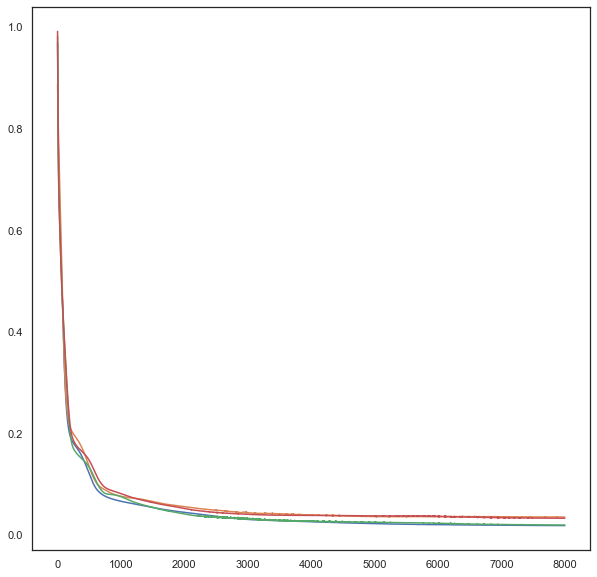

In [84]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.plot(losses)
plt.plot(val_losses)

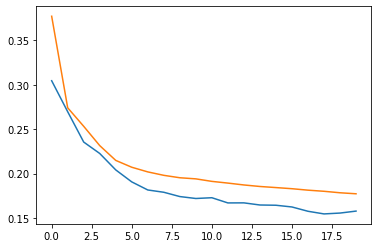

In [58]:
for h in range(len(hists)):
    plt.plot(hists[h].history['val_loss'])
    plt.plot(hists[h].history['loss'])

# Apply tuned model to flatground data

In [92]:
hist = []
losses_train = []
losses_test = []
dimvar = []
ae_vaf_test = []
ae_vaf_train = []
input_dim = x_train_flat.shape[1]
latent_dim = 2

for d in range(1,15):
    latent_dim = d
    ae = create_autoencoder_final(latent_dim, input_dim, np.clip(latent_dim,7,15))
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    K.set_value(ae.optimizer.learning_rate, 0.001)
    ae = train_num_iterations(ae, x_train_flat, x_train_flat, 32, 8000)
    #hist.append(ae.fit(x_train_flat, x_train_flat, epochs = 25, batch_size = 32, verbose = 0))
    
    inputLayer = Input(shape = (x_train_flat.shape[1]))    
    embedder = inputLayer
    for layer in ae.layers[:7]:
        embedder = layer(embedder)
    embedder = Model(inputs=inputLayer, outputs=embedder)
    activations = embedder(x_train_flat)
    
    dimvartemp = []
    for u in range(activations.shape[1]):
        dimvartemp.append(np.var(activations[:,u]))
    print(activations.shape)
    dimvar.append(dimvartemp)
    
    dec = ae.predict(x_test_flat)
    loss = ((x_test_flat - dec) ** 2).mean()
    losses_test.append(loss)
    ae_vaf_test.append((1 - ((np.var(x_test_flat - dec)) / (np.var(x_test_flat)))) * 100)
    
    dec = ae.predict(x_train_flat)
    loss = ((x_train_flat - dec) ** 2).mean()
    losses_train.append(loss)
    ae_vaf_train.append((1 - ((np.var(x_train_flat - dec)) / (np.var(x_train_flat)))) * 100)
    
    print('Latent dim: ' + str(d) + ' with train loss: ' + str(loss))

(38196, 1). 99.99%
Latent dim: 1 with train loss: 0.17935681308486467
(38196, 2). 99.99%
Latent dim: 2 with train loss: 0.128319494945215
(38196, 3). 99.99%
Latent dim: 3 with train loss: 0.09315078270522367
(38196, 4). 99.99%
Latent dim: 4 with train loss: 0.08969610071720087
(38196, 5). 99.99%
Latent dim: 5 with train loss: 0.06123873723423712
(38196, 6). 99.99%
Latent dim: 6 with train loss: 0.048981043226598575
(38196, 7). 99.99%
Latent dim: 7 with train loss: 0.043597638179738114
(38196, 8). 99.99%
Latent dim: 8 with train loss: 0.034370102956288395
(38196, 9). 99.99%
Latent dim: 9 with train loss: 0.027471600780240742
(38196, 10) 99.99%
Latent dim: 10 with train loss: 0.01997715505990831
(38196, 11) 99.99%
Latent dim: 11 with train loss: 0.01418656359249079
(38196, 12) 99.99%
Latent dim: 12 with train loss: 0.012577980423507483
(38196, 13) 99.99%
Latent dim: 13 with train loss: 0.010627071160064191
(38196, 14) 99.99%
Latent dim: 14 with train loss: 0.0007557851291217368


### Generate 2d embedding

In [57]:
input_dim = x_train_flat.shape[1]
latent_dim = 2
ae = create_autoencoder_final(2, input_dim, 7)
opt = Adam(learning_rate=0.001)
ae.compile(loss='mse', loss_weights=1, optimizer=opt)
ae.fit(x_train_flat, x_train_flat, epochs = 25, batch_size = 32, verbose = 0)
ae.save('models/ae-flat.h5')


In [ ]:
ae = keras.models.load_model('models/ae-flat.h5')
inputLayer = Input(shape = (14))    
embedder = inputLayer
for layer in ae.layers[:7]:
    embedder = layer(embedder)
embedder = Model(inputs=inputLayer, outputs=embedder)
activations = embedder(x_train_flat[:,0,:])

y = np.sin(np.arange(-1,99,0.3))
y = np.multiply(y,(np.arange(0.5,1.5, 1/334)))
y += np.sin(np.arange(0, 3, 3/334))
plt.scatter(activations[:,0],activations[:,1],s=0.5,color = 'indigo')
#plt.savefig('figs/AE_2d_embedding_flat.png')

cycleSample = []
for t in range(60):
    acts = embedder(x_train_flat[1000:1001,t,:])
    cycleSample.append(acts)
    #plt.scatter(rep1[:,0], rep1[:,1], s = 20, color = 'black')
plt.plot(np.squeeze(np.array(cycleSample))[:,0],np.squeeze(np.array(cycleSample))[:,1], color = 'red', linewidth = 5)

### Spatiotemporal landscape

(50, 50)
(50, 50)


<Figure size 720x720 with 0 Axes>

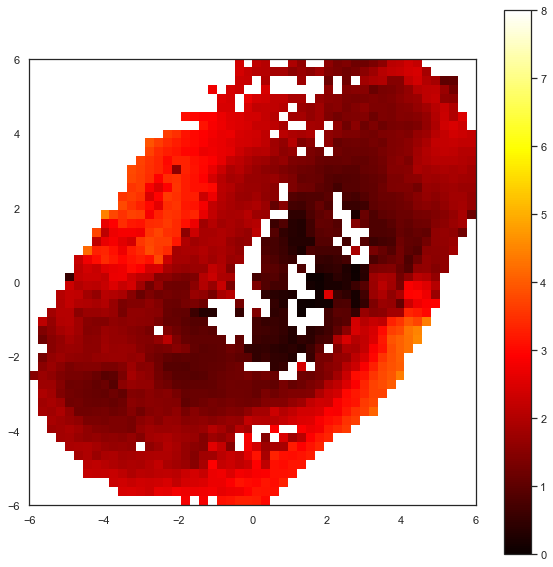

In [79]:
inputLayer = Input(shape = (2))    
decoder = inputLayer
for layer in ae.layers[7:]:
    decoder = layer(decoder)
decoder = Model(inputs=inputLayer, outputs=decoder)

#generate_spatial_variance_map_AE(decoder, activations, [-6, 6], [-6, 6])
generate_temporal_variance_map(activations, [-6, 6], [-6, 6])

# Apply tuned model to stairs data

In [117]:
hist = []
losses_train = []
losses_test = []
dimvar = []
ae_vaf_test = []
ae_vaf_train = []
input_dim = x_train_stairs.shape[1]
latent_dim = 2

for d in range(1,15):
    latent_dim = d
    ae = create_autoencoder_final(latent_dim, input_dim, np.clip(latent_dim,7,15))
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    ae = train_num_iterations(ae, x_train_stairs, x_train_stairs, 32, 8000)
    
    inputLayer = Input(shape = (x_train_stairs.shape[1]))    
    embedder = inputLayer
    for layer in ae.layers[:7]:
        embedder = layer(embedder)
    embedder = Model(inputs=inputLayer, outputs=embedder)
    activations = embedder(x_train_stairs)
    
    dimvartemp = []
    for u in range(activations.shape[1]):
        dimvartemp.append(np.var(activations[:,u]))
    print(activations.shape)
    dimvar.append(dimvartemp)
    
    dec = ae.predict(x_test_stairs)
    loss = ((x_test_stairs - dec) ** 2).mean()
    losses_test.append(loss)
    ae_vaf_test.append((1 - ((np.var(x_test_stairs - dec)) / (np.var(x_test_stairs)))) * 100)
    
    dec = ae.predict(x_train_stairs)
    loss = ((x_train_stairs - dec) ** 2).mean()
    losses_train.append(loss)
    ae_vaf_train.append((1 - ((np.var(x_train_stairs - dec)) / (np.var(x_train_stairs)))) * 100)
    
    print('Latent dim: ' + str(d) + ' with train loss: ' + str(loss))

(54755, 1). 99.99%
Latent dim: 1 with train loss: 0.38606919921991134
(54755, 2). 99.99%
Latent dim: 2 with train loss: 0.28732395327913623
(54755, 3). 99.99%
Latent dim: 3 with train loss: 0.2500403157155636
(54755, 4). 99.99%
Latent dim: 4 with train loss: 0.2044646814282023
(54755, 5). 99.99%
Latent dim: 5 with train loss: 0.16628670977046378
(54755, 6). 99.99%
Latent dim: 6 with train loss: 0.1350367219576575
(54755, 7). 99.99%
Latent dim: 7 with train loss: 0.10961765853275464
(54755, 8). 99.99%
Latent dim: 8 with train loss: 0.08986102530109688
(54755, 9). 99.99%
Latent dim: 9 with train loss: 0.07095132680830808
(54755, 10) 99.99%
Latent dim: 10 with train loss: 0.050730754326601485
(54755, 11) 99.99%
Latent dim: 11 with train loss: 0.04032501539686644
(54755, 12) 99.99%
Latent dim: 12 with train loss: 0.022790489858069383
(54755, 13) 99.99%
Latent dim: 13 with train loss: 0.021243502014318846
(54755, 14) 99.99%
Latent dim: 14 with train loss: 0.002932391885390649


### Generate 2d embedding

In [60]:
input_dim = x_train_flat.shape[1]
latent_dim = 2
ae = create_autoencoder_final(2, input_dim, 7)
opt = Adam(learning_rate=0.001)
ae.compile(loss='mse', loss_weights=1, optimizer=opt)
ae.fit(x_train_stairs, x_train_stairs, epochs = 25, batch_size = 32, verbose = 0)
ae.save('models/ae-stairs.h5')


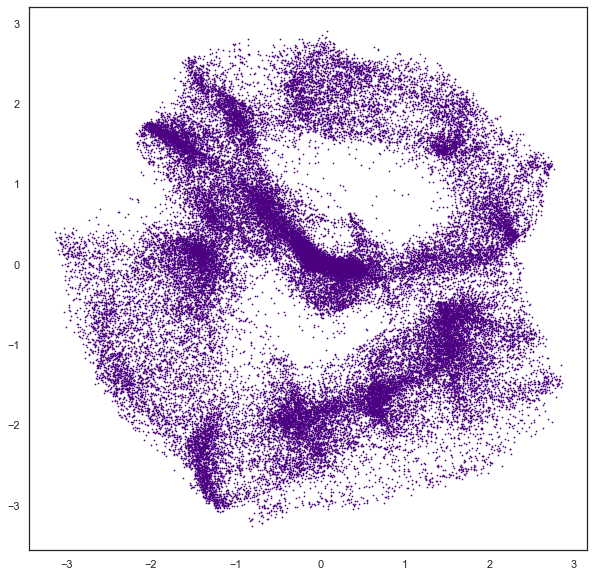

In [89]:
ae = keras.models.load_model('models/ae-stairs.h5')
inputLayer = Input(shape = (x_train_stairs.shape[2]))    
embedder = inputLayer
for layer in ae.layers[:7]:
    embedder = layer(embedder)
embedder = Model(inputs=inputLayer, outputs=embedder)
activations = embedder(x_train_stairs)

plt.scatter(activations[:,0],activations[:,1],s=0.5,color = 'indigo')
plt.savefig('figs/AE_2d_embedding_stairs.png')

(50, 50)
(50, 50)


<Figure size 720x720 with 0 Axes>

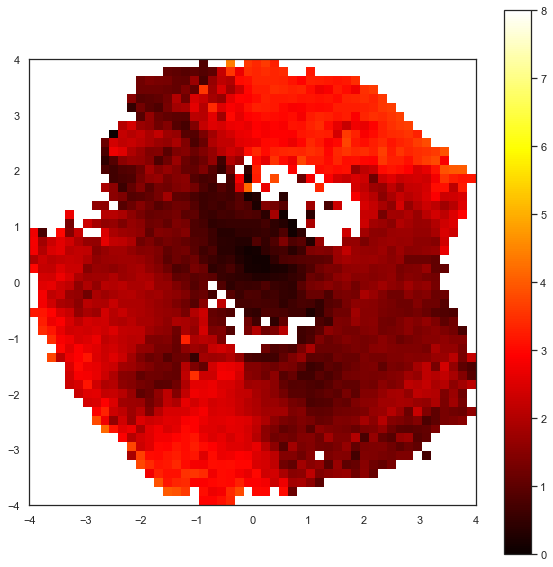

In [90]:
inputLayer = Input(shape = (2))    
decoder = inputLayer
for layer in ae.layers[7:]:
    decoder = layer(decoder)
decoder = Model(inputs=inputLayer, outputs=decoder)

#generate_spatial_variance_map_AE(decoder, activations, [-4, 4], [-4, 4])
generate_temporal_variance_map(activations, [-4, 4], [-4, 4])

# Apply tuned model to unstructured data

In [107]:
hist = []
losses_test = []
losses_train = []
dimvar = []
ae_vaf_test = []
ae_vaf_train = []
input_dim = x_train_unstructured.shape[1]
latent_dim = 2

for d in range(1,15):
    latent_dim = d
    ae = create_autoencoder_final(latent_dim, input_dim, np.clip(latent_dim,7,15))
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    ae = train_num_iterations(ae, x_train_unstructured, x_train_unstructured, 32, 8000)
    
    inputLayer = Input(shape = (x_train_unstructured.shape[1]))    
    embedder = inputLayer
    for layer in ae.layers[:7]:
        embedder = layer(embedder)
    embedder = Model(inputs=inputLayer, outputs=embedder)
    activations = embedder(x_train_unstructured)
    
    dimvartemp = []
    for u in range(activations.shape[1]):
        dimvartemp.append(np.var(activations[:,u]))
    print(activations.shape)
    dimvar.append(dimvartemp)
    
    
    dec = ae.predict(x_test_unstructured)
    loss = ((x_test_unstructured - dec) ** 2).mean()
    losses_test.append(loss)
    ae_vaf_test.append((1 - ((np.var(x_test_unstructured - dec)) / (np.var(x_test_unstructured)))) * 100)
    
    dec = ae.predict(x_train_unstructured)
    loss = ((x_train_unstructured - dec) ** 2).mean()
    losses_train.append(loss)
    ae_vaf_train.append((1 - ((np.var(x_train_unstructured - dec)) / (np.var(x_train_unstructured)))) * 100)
    
    print('Latent dim: ' + str(d) + ' with train loss: ' + str(loss))

(34779, 1). 99.99%
Latent dim: 1 with train loss: 0.8778173219340439
(34779, 2). 99.99%
Latent dim: 2 with train loss: 0.7025475575041533
(34779, 3). 99.99%
Latent dim: 3 with train loss: 0.6424509833740668
(34779, 4). 99.99%
Latent dim: 4 with train loss: 0.49539522743181486
(34779, 5). 99.99%
Latent dim: 5 with train loss: 0.43456880088725625
(34779, 6). 99.99%
Latent dim: 6 with train loss: 0.3692067726393785
(34779, 7). 99.99%
Latent dim: 7 with train loss: 0.3176360607728137
(34779, 8). 99.99%
Latent dim: 8 with train loss: 0.2655616046031563
(34779, 9). 99.99%
Latent dim: 9 with train loss: 0.2387194449853112
(34779, 10) 99.99%
Latent dim: 10 with train loss: 0.16590180980572602
(34779, 11) 99.99%
Latent dim: 11 with train loss: 0.19813793590308554
(34779, 12) 99.99%
Latent dim: 12 with train loss: 0.11698109383135731
(34779, 13) 99.99%
Latent dim: 13 with train loss: 0.03804724850785636
(34779, 14) 99.99%
Latent dim: 14 with train loss: 0.04171609111810514


### Generate 2d embedding

In [64]:
input_dim = x_train_flat.shape[1]
latent_dim = 2
ae = create_autoencoder_final(2, input_dim, 7)
opt = Adam(learning_rate=0.001)
ae.compile(loss='mse', loss_weights=1, optimizer=opt)
ae.fit(x_train_unstructured, x_train_unstructured, epochs = 25, batch_size = 32, verbose = 0)
ae.save('models/ae-unstructured.h5')



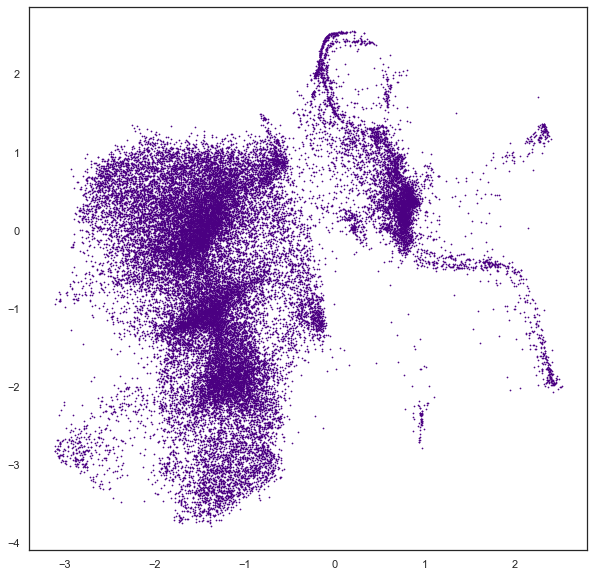

In [81]:
ae = keras.models.load_model('models/ae-unstructured.h5')
inputLayer = Input(shape = (x_train_unstructured.shape[1]))    
embedder = inputLayer
for layer in ae.layers[:7]:
    embedder = layer(embedder)
embedder = Model(inputs=inputLayer, outputs=embedder)
activations = embedder(x_train_unstructured)

plt.scatter(activations[:,0],activations[:,1],s=0.5,color = 'indigo')
plt.savefig('figs/AE_2d_embedding_unstructured.png')

(50, 50)
(50, 50)


<Figure size 720x720 with 0 Axes>

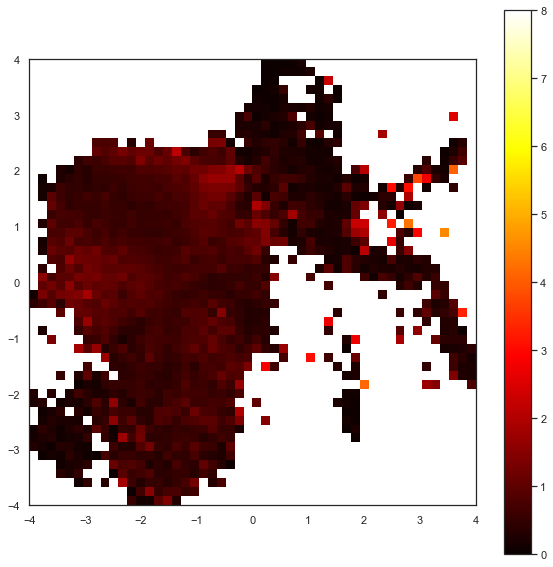

In [82]:
inputLayer = Input(shape = (2))    
decoder = inputLayer
for layer in ae.layers[7:]:
    decoder = layer(decoder)
decoder = Model(inputs=inputLayer, outputs=decoder)

#generate_spatial_variance_map_AE(decoder, activations, [-4, 4], [-4, 4])
generate_temporal_variance_map(activations, [-4, 4], [-4, 4])

# Apply tuned model to combined dataset

In [20]:
input_dim = 14
latent_dim = 2

x_combined = np.vstack([x_train_flat, x_train_stairs, x_train_unstructured])

ae = create_autoencoder_final(2, input_dim, 7)
opt = Adam(learning_rate=0.001)
ae.compile(loss='mse', loss_weights=1, optimizer=opt)
ae.fit(x_combined, x_combined, epochs = 25, batch_size = 32, verbose = 0, shuffle = True)
ae.save('models/ae-combined.h5')

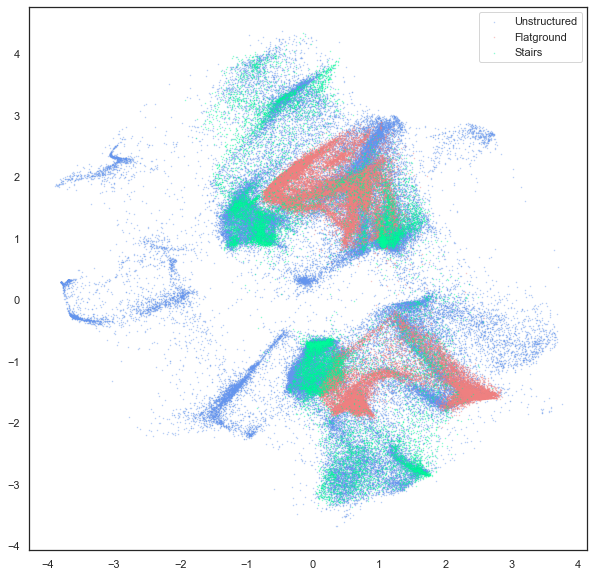

In [83]:
ae = keras.models.load_model('models/ae-combined.h5')
inputLayer = Input(shape = (x_combined.shape[1]))    
embedder = inputLayer
for layer in ae.layers[:7]:
    embedder = layer(embedder)
embedder = Model(inputs=inputLayer, outputs=embedder)
activations = embedder(x_combined)

plt.scatter(activations[x_train_stairs.shape[0]:,0],activations[x_train_stairs.shape[0]:,1],s=0.2,color = 'cornflowerblue', alpha = 0.5)
plt.scatter(activations[:x_train_flat.shape[0],0],activations[:x_train_flat.shape[0],1],s=0.2,color = 'lightcoral', alpha = 0.5)
plt.scatter(activations[x_train_flat.shape[0]:x_train_stairs.shape[0],0],activations[x_train_flat.shape[0]:x_train_stairs.shape[0],1],s=0.2,color = 'mediumspringgreen', alpha = 0.5)
plt.legend(['Unstructured','Flatground','Stairs'])
plt.savefig('figs/AE_2d_embedding_combined.png')

(50, 50)
(50, 50)


<Figure size 720x720 with 0 Axes>

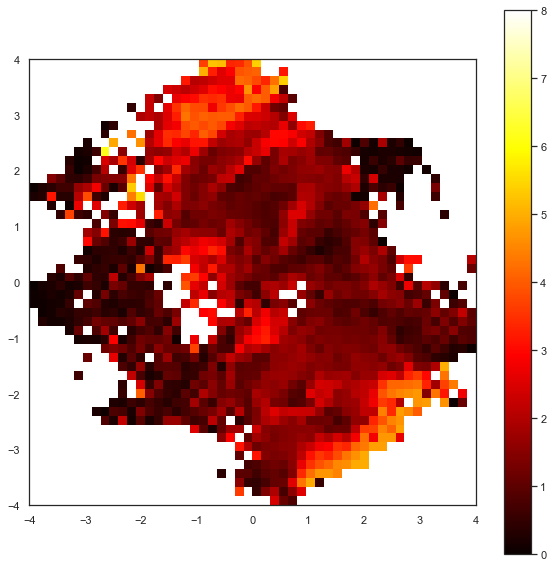

In [84]:
inputLayer = Input(shape = (2))    
decoder = inputLayer
for layer in ae.layers[7:]:
    decoder = layer(decoder)
decoder = Model(inputs=inputLayer, outputs=decoder)

#generate_spatial_variance_map_AE(decoder, activations, [-4, 4], [-4, 4])
generate_temporal_variance_map(activations, [-4, 4], [-4, 4])

# Apply PCA

### Flatground

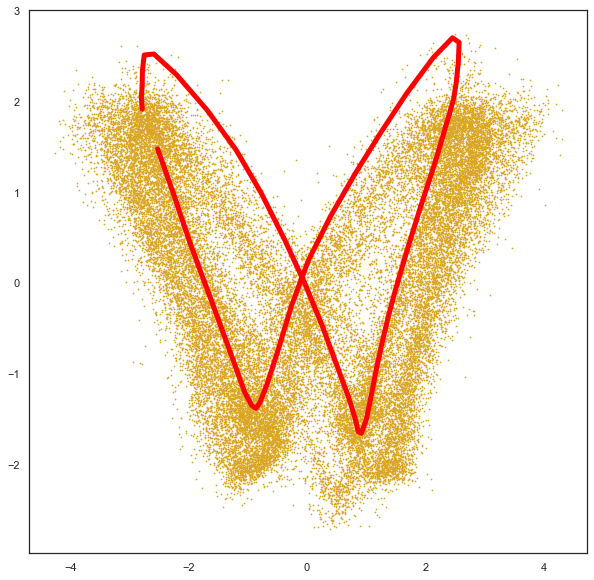

In [38]:
from sklearn.decomposition import KernelPCA, PCA # for PCA calculation

pca_vaf_train = []
pca_vaf_test = []
pca_reconLoss = []
for p in range(1,15):
    pca = PCA(n_components = p)
    red = pca.fit_transform(x_train_flat[:,0,:])
    #print(red.shape)
    y_pca = pca.inverse_transform(red)
    #print(y_pca.shape)
    #redtest_pca = pca.transform(x_test_flat)
    #ytest_pca = pca.inverse_transform(redtest_pca)
    #loss = ((x_test_flat - ytest_pca) ** 2).mean()
    #pca_reconLoss.append(loss)
    #pca_vaf_test.append((1 - ((np.var(x_test_flat - ytest_pca)) / (np.var(x_test_flat)))) * 100)
    #pca_vaf_train.append((1 - ((np.var(x_train_flat - y_pca)) / (np.var(x_train_flat)))) * 100)
    #print(str(p) + ' components reconstruction loss: ' + str(loss))

cycleSample = []
plt.scatter(red[:,0],red[:,1], s = 0.5, color = 'goldenrod')
for t in range(59):
    rep1 = pca.transform(x_train_flat[1000:1001,t,:])
    cycleSample.append(rep1[:,:2])
    #plt.scatter(rep1[:,0], rep1[:,1], s = 20, color = 'black')
plt.plot(np.squeeze(np.array(cycleSample))[:,0],np.squeeze(np.array(cycleSample))[:,1], color = 'red', linewidth = 5)
#plt.savefig('figs/PCA_2d_embedding_flat.png')

#plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
#plt.plot(pca_vaf_train)
#plt.plot(pca_vaf_test)

#generate_spatial_variance_map_PCA(pca, red, [-4, 4], [-3, 3])
#generate_temporal_variance_map(red[:,:2], [-4, 4], [-3, 3])

In [37]:
np.squeeze(np.array(cycleSample)).shape

(59, 2)

### Stairs

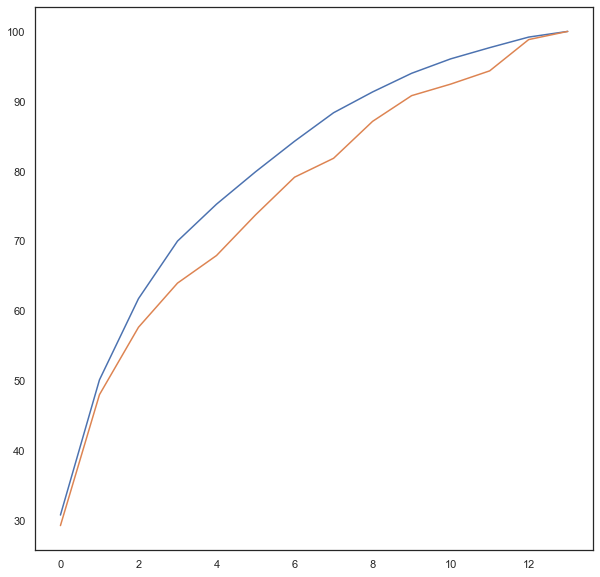

In [120]:
from sklearn.decomposition import KernelPCA, PCA # for PCA calculation

pca_vaf_train = []
pca_vaf_test = []
pca_reconLoss = []
for p in range(1,15):
    pca = PCA(n_components = p)
    red = pca.fit_transform(x_train_stairs)
    #print(red.shape)
    y_pca = pca.inverse_transform(red)
    #print(y_pca.shape)
    redtest_pca = pca.transform(x_test_stairs)
    ytest_pca = pca.inverse_transform(redtest_pca)
    loss = ((x_test_stairs - ytest_pca) ** 2).mean()
    pca_reconLoss.append(loss)
    pca_vaf_train.append((1 - ((np.var(x_train_stairs - y_pca)) / (np.var(x_train_stairs)))) * 100)
    pca_vaf_test.append((1 - ((np.var(x_test_stairs - ytest_pca)) / (np.var(x_test_stairs)))) * 100)
    #print(str(p) + ' components reconstruction loss: ' + str(loss))

#plt.scatter(redtest_pca[:,0],redtest_pca[:,1], s = 0.5, color = 'goldenrod')
#plt.savefig('figs/PCA_2d_embedding_stairs.png')

#plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.plot(pca_vaf_train)
plt.plot(pca_vaf_test)

#generate_spatial_variance_map_PCA(pca, red, [-6, 6], [-5, 4])
#generate_temporal_variance_map(red[:,:2], [-4, 4], [-3, 3])

### Unstructured

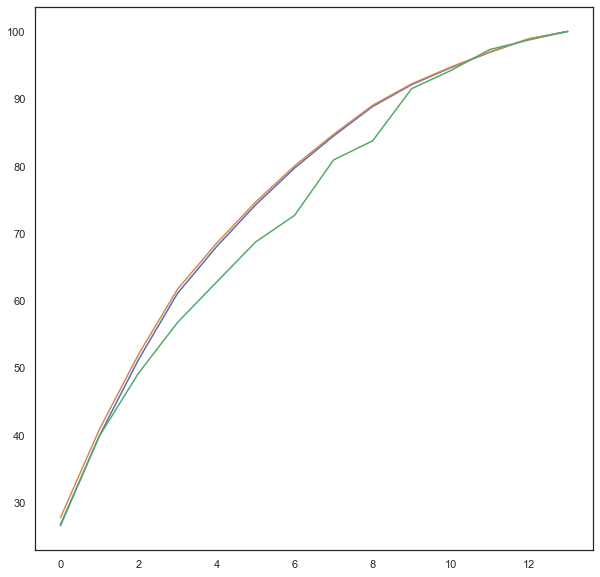

In [112]:
from sklearn.decomposition import KernelPCA, PCA # for PCA calculation

pca_vaf = []
pca_vaf_train = []
pca_vaf_test = []
pca_reconLoss = []
for p in range(1,15):
    pca = PCA(n_components = p)
    red = pca.fit_transform(x_train_unstructured)
    #print(red.shape)
    y_pca = pca.inverse_transform(red)
    #print(y_pca.shape)
    redtest_pca = pca.transform(x_test_unstructured)
    ytest_pca = pca.inverse_transform(redtest_pca)
    loss = ((x_test_unstructured - ytest_pca) ** 2).mean()
    pca_reconLoss.append(loss)
    pca_vaf_test.append((1 - ((np.var(x_test_unstructured - ytest_pca)) / (np.var(x_test_unstructured )))) * 100)
    pca_vaf_train.append((1 - ((np.var(x_train_unstructured - y_pca)) / (np.var(x_train_unstructured )))) * 100)
    #print(str(p) + ' components reconstruction loss: ' + str(loss))

#plt.scatter(redtest_pca[:,0],redtest_pca[:,1], s = 0.5, color = 'goldenrod')
#plt.savefig('figs/PCA_2d_embedding_unstructured.png')
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.plot(pca_vaf_train)
plt.plot(pca_vaf_test)
#generate_spatial_variance_map_PCA(pca, red, [-5, 10], [-8, 8])
#generate_temporal_variance_map(red[:,:2], [-4, 4], [-3, 3])

### Combined

(50, 50)
(50, 50)


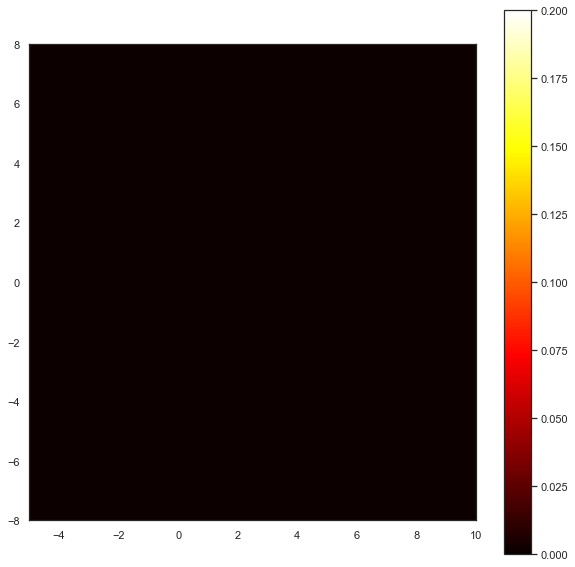

<Figure size 720x720 with 0 Axes>

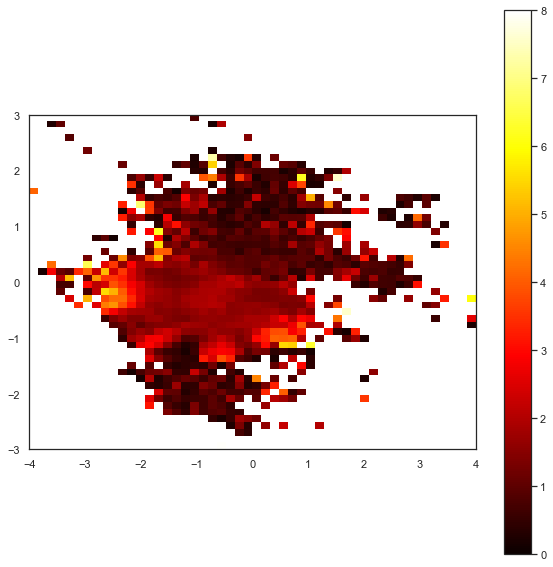

In [88]:
from sklearn.decomposition import KernelPCA, PCA # for PCA calculation

pca_reconLoss = []
for p in range(1,15):
    pca = PCA(n_components = p)
    red = pca.fit_transform(x_combined)
    #print(red.shape)
    y_pca = pca.inverse_transform(red)
    #print(y_pca.shape)
    redtest_pca = pca.transform(x_combined)
    ytest_pca = pca.inverse_transform(redtest_pca)
    loss = ((x_combined - ytest_pca) ** 2).mean()
    pca_reconLoss.append(loss)
    #print(str(p) + ' components reconstruction loss: ' + str(loss))

#plt.scatter(redtest_pca[x_train_stairs.shape[0]:,0],redtest_pca[x_train_stairs.shape[0]:,1],s=0.2,color = 'cornflowerblue', alpha = 0.5)
#plt.scatter(redtest_pca[:x_train_flat.shape[0],0],redtest_pca[:x_train_flat.shape[0],1],s=0.2,color = 'lightcoral', alpha = 0.5)
#plt.scatter(redtest_pca[x_train_flat.shape[0]:x_train_stairs.shape[0],0],redtest_pca[x_train_flat.shape[0]:x_train_stairs.shape[0],1],s=0.2,color = 'mediumspringgreen', alpha = 0.5)
#plt.legend(['Unstructured','Flatground','Stairs'])
#ax = plt.gca()
#leg = ax.get_legend()
#leg.legendHandles[0].set_color('cornflowerblue')
#leg.legendHandles[1].set_color('lightcoral')
#leg.legendHandles[2].set_color('mediumspringgreen')
#plt.savefig('figs/PCA_2d_embedding_combined.png')
#generate_spatial_variance_map_PCA(pca, red, [-5, 10], [-8, 8])
#generate_temporal_variance_map(red[:,:2], [-4, 4], [-3, 3])

# Generate figures

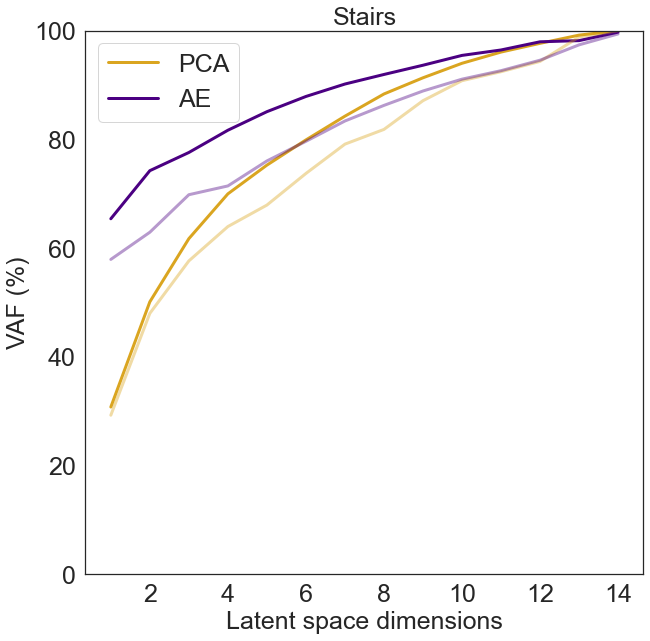

In [124]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(10,10)})
pca_reconPercent = [(1-x)*100 for x in pca_reconLoss]
lossesPercent = [(1-x)*100 for x in losses]

plt.figure(0)
plt.title("Stairs", fontsize = 25)
plt.plot(range(1,15), pca_vaf_train,  linewidth = 3, color = 'goldenrod')
plt.plot(range(1,15), ae_vaf_train, linewidth = 3, color = 'indigo')
plt.plot(range(1,15), pca_vaf_test,  linewidth = 3, color = 'goldenrod', alpha = 0.4)
plt.plot(range(1,15), ae_vaf_test, linewidth = 3, color = 'indigo', alpha = 0.4)
plt.xlabel("Latent space dimensions", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylabel("VAF (%)", fontsize = 25)
plt.legend(['PCA','AE'], fontsize =25)
plt.ylim(0, 100)
plt.savefig('figs/Stairs-VAF-withTest.png')
# plt.figure(1)
# plt.title("Variance explained per PC", fontsize = 25)
# plt.bar(range(1,15),pca.explained_variance_ratio_)
# plt.xlabel("# of PCs", fontsize = 25)
# plt.xticks(fontsize = 25)
# plt.yticks(fontsize = 25)
# plt.ylabel("Ratio of total variance", fontsize = 25)

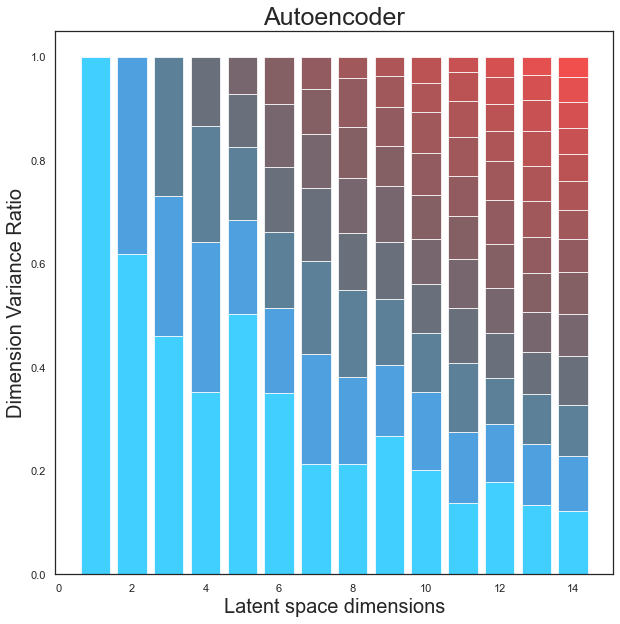

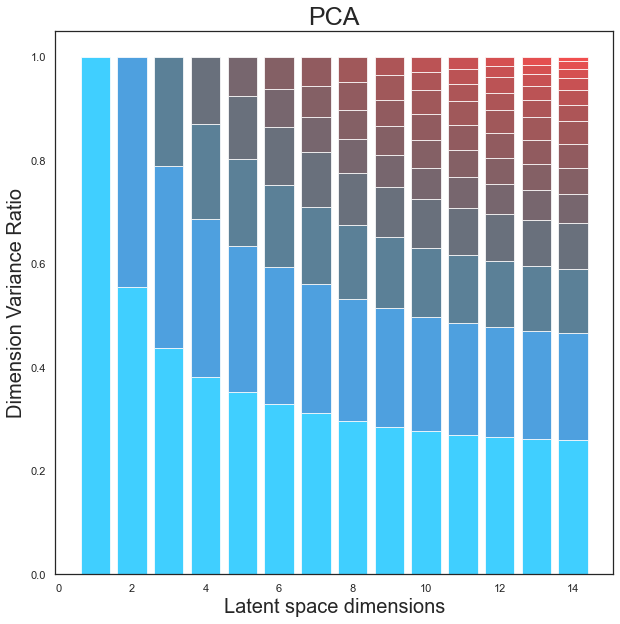

In [125]:
dimvarRatio = dimvar.copy()
for d in dimvarRatio:
    d.sort(reverse = True)
for d in range(len(dimvarRatio)):
    dimvarRatio[d] = dimvarRatio[d]/sum(dimvarRatio[d])

colors = np.full((14,14), np.arange(14))
plt.figure(0)
for d in range(0, len(dimvarRatio)):
    for v in range(0,len(dimvarRatio[d])):
        if v > 0:
            plt.bar(d+1, dimvarRatio[d][v], bottom = sum(dimvarRatio[d][:v]), alpha = 0.75, color = (v/14,1/(v+1),1/(v+0.2)))
        else:
            plt.bar(d+1, dimvarRatio[d][v], alpha = 0.75, color = (v/14,0.75,1))

plt.title('Autoencoder', fontsize = 25)
plt.xlabel('Latent space dimensions', fontsize = 20)
plt.ylabel('Dimension Variance Ratio', fontsize = 20)
plt.savefig('figs/Natural-DimVar-AE.png')


plt.figure(1)
for group in range(1,15):
    for pc in range(14):
        if pc < group:
            if pc > 0:
                plt.bar(group, pca.explained_variance_ratio_[pc]/sum(pca.explained_variance_ratio_[:group]), bottom = sum(pca.explained_variance_ratio_[:pc])/sum(pca.explained_variance_ratio_[:group]), alpha = 0.75, color = (pc/14,1/(pc+1),1/(pc+0.2)))
            else:
                plt.bar(group, pca.explained_variance_ratio_[pc]/sum(pca.explained_variance_ratio_[:group]), bottom = sum(pca.explained_variance_ratio_[:pc])/sum(pca.explained_variance_ratio_[:group]), alpha = 0.75, color = (0,0.75,1))
                                
plt.title('PCA', fontsize = 25)
plt.xlabel('Latent space dimensions', fontsize = 20)
plt.ylabel('Dimension Variance Ratio', fontsize = 20)
plt.savefig('figs/Natural-DimVar-PCA.png')


# Reconstruction by dataset

### Get reconstruction loss, plot by dataset

In [24]:
from sklearn.decomposition import PCA # for PCA calculation

# Generate PCA predictions, calculate error
pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_flat[:,0,:])
red = pca.transform(x_test_flat)
y_pca = pca.inverse_transform(red)
loss_flat_pca = np.sqrt(np.mean((x_test_flat - y_pca)**2))
print(loss_flat_pca)

pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_stairs)
red = pca.transform(x_test_stairs)
y_pca = pca.inverse_transform(red)
loss_stairs_pca = np.sqrt(np.mean((x_test_stairs - y_pca)**2))
print(loss_stairs_pca)

pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_unstructured)
red = pca.transform(x_test_unstructured)
y_pca = pca.inverse_transform(red)
loss_natural_pca = np.sqrt(np.mean((x_test_unstructured - y_pca)**2))
print(loss_natural_pca)

0.634033869303787
0.7979953966218698
1.0522663325128194


In [25]:
losses_flat = []
for r in range(10):
    ae = create_autoencoder_final(2, 14, 7)
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    K.set_value(ae.optimizer.learning_rate, 0.001)
    ae = train_num_iterations(ae, x_train_flat[:,0,:], x_train_flat[:,0,:], 32, 8000)
    aeflat_dec = ae.predict(x_test_flat)
    loss_flat_ae = np.sqrt(np.mean((x_test_flat - aeflat_dec)**2))
    print(loss_flat_ae)
    losses_flat.append(loss_flat_ae)

0.5310071553451031
0.5589560441499444
0.5568658559953695
0.5534365104396102
0.5508511102525829
0.5461930283344553
0.5317454975093991
0.5493704334781643
0.5598838487977689
0.5518286532271698


In [26]:
losses_stairs = []
for r in range(10):
    ae = create_autoencoder_final(2, 14, 7)
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    K.set_value(ae.optimizer.learning_rate, 0.001)
    ae = train_num_iterations(ae, x_train_stairs, x_train_stairs, 32, 8000)
    aestairs_dec = ae.predict(x_test_stairs)
    loss_stairs_ae = np.sqrt(np.mean((x_test_stairs - aestairs_dec)**2))
    print(loss_stairs_ae)
    losses_stairs.append(loss_stairs_ae)

0.7030368821412701
0.7106511370869242
0.7059316467092115
0.7070410737112984
0.710783634621197%
0.7081683088667096
0.7059236712275716
0.6953956799993669
0.7035815434445477
0.7050927230145436


In [28]:
losses_natural = []
for r in range(10):
    ae = create_autoencoder_final(2, 14, 7)
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    K.set_value(ae.optimizer.learning_rate, 0.001)
    ae = train_num_iterations(ae, x_train_unstructured, x_train_unstructured, 32, 8000)
    aenatural_dec = ae.predict(x_test_unstructured)
    loss_natural_ae = np.sqrt(np.mean((x_test_unstructured - aenatural_dec)**2))
    print(loss_natural_ae)
    losses_natural.append(loss_natural_ae)

1.0105920428606052
1.0120753104888585
1.0393659235646515
1.0159079362710444
1.0050141944695499
1.0308596435182273
1.009966233017191%
1.042484429296213%
1.004238520815508%
1.029955833822143%


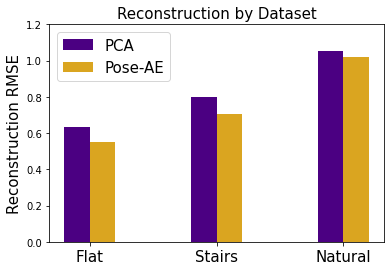

In [176]:
heights = [loss_flat_pca, np.mean(losses_flat), loss_stairs_pca, np.mean(losses_stairs), loss_natural_pca, np.mean(losses_natural)]
places = [-0.1, 0.1, 0.9, 1.1, 1.9, 2.1]
stds = [0, np.std(losses_flat), 0, np.std(losses_stairs), 0, np.std(losses_natural)]
plt.ylim(0,1.2)
# flat
plt.bar(places[0], heights[0], width = 0.2, align='center', color = 'indigo');
plt.bar(places[1], heights[1], width = 0.2, align='center', color = 'goldenrod');
#plt.errorbar(places[1], heights[1], stds[1], capsize = 4, capthick = 1, linewidth = 1, linestyle='None', color = 'black', barsabove =False);
# stairs
plt.bar(places[2], heights[2], width = 0.2, align='center', color = 'indigo');
plt.bar(places[3], heights[3], width = 0.2, align='center', color = 'goldenrod');
#plt.errorbar(places[3], heights[3], stds[3], capsize = 4, capthick = 1, linewidth = 1, linestyle='None', color = 'black', barsabove =False);
# natural
plt.bar(places[4], heights[4], width = 0.2, align='center', color = 'indigo');
plt.bar(places[5], heights[5], width = 0.2, align='center', color = 'goldenrod');
#plt.errorbar(places[5], heights[5], stds[5], capsize = 4, capthick = 1, linewidth = 1, linestyle='None', color = 'black', barsabove =False);

plt.xticks([0,1,2], ['Flat','Stairs','Natural'], fontsize=15);
plt.yticks(fontsize=10);
plt.ylabel('Reconstruction RMSE', fontsize = 15)
plt.title('Reconstruction by Dataset', fontsize = 15)
plt.legend(['PCA','Pose-AE'], fontsize = 15)
# plt.plot([1, 1, 2, 2], [0.6, 0.65, 0.65, 0.6], color = 'black')
# plt.annotate('*', (1.5, 0.65), fontsize = 20)

#plt.savefig('figs/Barchart-Recon.png')

In [177]:
print(heights)

[0.634033869303787, 0.5490138137529568, 0.7979953966218698, 0.7055606300822641, 1.0522663325128194, 1.020046006812399]


# Visualize Sample in Unity

## Flat sample

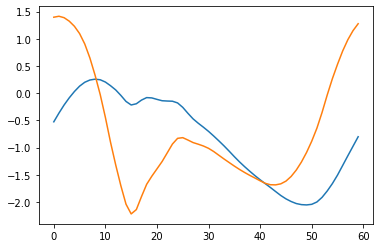

In [84]:
# find a good sample
plt.plot(x_train_flat[777,:,9])
plt.plot(x_train_flat[777,:,10])

In [93]:
# Real joint angles
legIdx = np.array(legs).astype(int)
realFlatSample = x_train_flat[777,30,:].copy()
for j in range(len(legs)):
    realFlatSample[j] = (x_train_flat[777,30,j] * jointSTDs[legs[j]]) + jointMeans[legs[j]]
print('Real joint angles')
for j in range(len(legs)):
    print(str(j) + ' ' + jointLabels[legs[j]] + '  ' + str(realFlatSample[j]))

# Generate PCA predictions
pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_flat[:,0,:])
red = pca.transform(x_train_flat[777:778,30,:])
y_pca = pca.inverse_transform(red)   
pcaFlatSample = y_pca.copy()
for j in range(len(legs)):
    pcaFlatSample[0,j] = (y_pca[0,j] * jointSTDs[legs[j]]) + jointMeans[legs[j]]
print(' ')
print('PCA transformed joint angles')
for j in range(len(legs)):
    print(str(j) + ' ' + jointLabels[legs[j]] + '  ' + str(pcaFlatSample[0,j]))
    
    
# Generate AE prediction
ae = keras.models.load_model('models/ae-flat.h5')
dec = ae.predict(x_train_flat[777:778,30,:])
aeFlatSample = dec.copy()
for j in range(len(legs)):
    aeFlatSample[0,j] = (dec[0,j] * jointSTDs[legs[j]]) + jointMeans[legs[j]]
print(' ')
print('Pose-AE transformed joint angles')
for j in range(len(legs)):
    print(str(j) + ' ' + jointLabels[legs[j]] + '  ' + str(aeFlatSample[0,j]))

Real joint angles
0 ang_jRightHip_Frontal  8.965017999999999
1 ang_jRightHip_Trans  -13.19328
2 ang_jRightHip_Sagittal  10.83041
3 ang_jRightKnee_Sagittal  62.06901
4 ang_jRightAnkle_Frontal  -2.50107
5 ang_jRightAnkle_Trans  -5.523443
6 ang_jRightAnkle_Sagittal  -22.55435
7 ang_jLeftHip_Frontal  -8.459315
8 ang_jLeftHip_Trans  -4.275047
9 ang_jLeftHip_Sagittal  11.23921
10 ang_jLeftKnee_Sagittal  15.59421
11 ang_jLeftAnkle_Frontal  -7.097987
12 ang_jLeftAnkle_Trans  -9.360075
13 ang_jLeftAnkle_Sagittal  0.42396199999999995
 
PCA transformed joint angles
0 ang_jRightHip_Frontal  7.186689675427764
1 ang_jRightHip_Trans  -6.956940221031891
2 ang_jRightHip_Sagittal  13.425965881280572
3 ang_jRightKnee_Sagittal  64.27438840048606
4 ang_jRightAnkle_Frontal  -5.96135472167899
5 ang_jRightAnkle_Trans  2.776008982618001
6 ang_jRightAnkle_Sagittal  -18.279588633211493
7 ang_jLeftHip_Frontal  -6.07603667528865
8 ang_jLeftHip_Trans  -4.656080950236682
9 ang_jLeftHip_Sagittal  0.3972282520030568
1

## Stairs sample

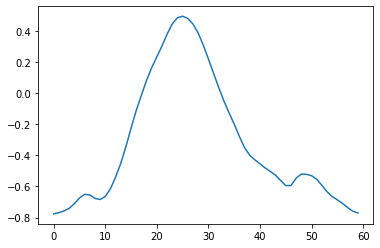

In [111]:
# find a good sample
plt.plot(x_train_stairs[17777,25,2])

In [121]:
#Real joint angles
legIdx = np.array(legs).astype(int)
realStairsSample = x_train_stairs[17777,25,:].copy()
for j in range(len(legs)):
    realFlatSample[j] = (x_train_stairs[17777,25,j] * jointSTDs[legs[j]]) + jointMeans[legs[j]]
print('Real joint angles')
for j in range(len(legs)):
    print(str(j) + ' ' + jointLabels[legs[j]] + '  ' + str(realFlatSample[j]))
    
# Generate PCA predictions
pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_stairs[:,0,:])
red = pca.transform(x_train_stairs[17777:17778,25,:])
y_pca = pca.inverse_transform(red)   
pcaFlatSample = y_pca.copy()
for j in range(len(legs)):
    pcaFlatSample[0,j] = (y_pca[0,j] * jointSTDs[legs[j]]) + jointMeans[legs[j]]
print(' ')
print('PCA transformed joint angles')
for j in range(len(legs)):
    print(str(j) + ' ' + jointLabels[legs[j]] + '  ' + str(pcaFlatSample[0,j]))
    
# Generate AE prediction
ae = keras.models.load_model('models/ae-stairs.h5')
dec = ae.predict(x_train_stairs[17777:17778,25,:])
aeStairsSample = dec.copy()
for j in range(len(legs)):
    aeStairsSample[0,j] = (dec[0,j] * jointSTDs[legs[j]]) + jointMeans[legs[j]]
print(' ')
print('Pose-AE transformed joint angles')
for j in range(len(legs)):
    print(str(j) + ' ' + jointLabels[legs[j]] + '  ' + str(aeStairsSample[0,j]))

Real joint angles
0 ang_jRightHip_Frontal  1.51789
1 ang_jRightHip_Trans  -1.813418
2 ang_jRightHip_Sagittal  33.467079999999996
3 ang_jRightKnee_Sagittal  69.03026
4 ang_jRightAnkle_Frontal  4.8759
5 ang_jRightAnkle_Trans  -3.7835449999999997
6 ang_jRightAnkle_Sagittal  -5.32709
7 ang_jLeftHip_Frontal  -0.34064400000000006
8 ang_jLeftHip_Trans  -9.11313
9 ang_jLeftHip_Sagittal  13.627320000000001
10 ang_jLeftKnee_Sagittal  28.35298
11 ang_jLeftAnkle_Frontal  15.13018
12 ang_jLeftAnkle_Trans  -0.9416180000000001
13 ang_jLeftAnkle_Sagittal  13.104999999999999
 
PCA transformed joint angles
0 ang_jRightHip_Frontal  4.798218741376509
1 ang_jRightHip_Trans  -0.9881818058614469
2 ang_jRightHip_Sagittal  24.752528480095854
3 ang_jRightKnee_Sagittal  49.386367299216246
4 ang_jRightAnkle_Frontal  -6.348943103853005
5 ang_jRightAnkle_Trans  -1.8738063529062012
6 ang_jRightAnkle_Sagittal  -1.8528187472136006
7 ang_jLeftHip_Frontal  -1.6603535730008585
8 ang_jLeftHip_Trans  -8.077180091524678
9 a

## Natural sample

In [164]:
# find a good sample

#Real joint angles
legIdx = np.array(legs).astype(int)
realUnsSample = x_train_unstructured[2100,:].copy()
for j in range(len(legs)):
    realUnsSample[j] = (x_train_unstructured[2100,j] * jointSTDs[legs[j]]) + jointMeans[legs[j]]
print('Real joint angles')
for j in range(len(legs)):
    print(str(j) + ' ' + jointLabels[legs[j]] + '  ' + str(realUnsSample[j]))
    
# Generate PCA predictions
pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_unstructured)
red = pca.transform(x_train_unstructured[2100:2101,:])
y_pca = pca.inverse_transform(red)   
pcaNatSample = y_pca.copy()
for j in range(len(legs)):
    pcaNatSample[0,j] = (y_pca[0,j] * jointSTDs[legs[j]]) + jointMeans[legs[j]]
print(' ')
print('PCA transformed joint angles')
for j in range(len(legs)):
    print(str(j) + ' ' + jointLabels[legs[j]] + '  ' + str(pcaNatSample[0,j]))
    
# Generate AE prediction
ae = keras.models.load_model('models/ae-unstructured.h5')
dec = ae.predict(x_train_unstructured[2100:2101,:])
aeNatSample = dec.copy()
for j in range(len(legs)):
    aeNatSample[0,j] = (dec[0,j] * jointSTDs[legs[j]]) + jointMeans[legs[j]]
print(' ')
print('Pose-AE transformed joint angles')
for j in range(len(legs)):
    print(str(j) + ' ' + jointLabels[legs[j]] + '  ' + str(aeNatSample[0,j]))

Real joint angles
0 ang_jRightHip_Frontal  -9.989638
1 ang_jRightHip_Trans  -2.20402
2 ang_jRightHip_Sagittal  0.3651810000000033
3 ang_jRightKnee_Sagittal  4.456053000000001
4 ang_jRightAnkle_Frontal  4.576713999999999
5 ang_jRightAnkle_Trans  -1.2454330000000007
6 ang_jRightAnkle_Sagittal  9.244659
7 ang_jLeftHip_Frontal  1.608923
8 ang_jLeftHip_Trans  -5.398282
9 ang_jLeftHip_Sagittal  36.193051
10 ang_jLeftKnee_Sagittal  10.845216999999998
11 ang_jLeftAnkle_Frontal  -9.526164
12 ang_jLeftAnkle_Trans  -6.821348
13 ang_jLeftAnkle_Sagittal  7.592705
 
PCA transformed joint angles
0 ang_jRightHip_Frontal  0.96064513168939
1 ang_jRightHip_Trans  -4.399788294429682
2 ang_jRightHip_Sagittal  10.583509009851076
3 ang_jRightKnee_Sagittal  18.162639177544456
4 ang_jRightAnkle_Frontal  -1.7512747761580982
5 ang_jRightAnkle_Trans  -6.114280121371183
6 ang_jRightAnkle_Sagittal  4.846388672902853
7 ang_jLeftHip_Frontal  0.8124994026241199
8 ang_jLeftHip_Trans  -4.994604536406765
9 ang_jLeftHip_S

In [ ]:
# frontal - pos = adduction, neg = abduction
# frontal ankle - pos = inversion, neg = eversion
# transverse - pos = internal rot, neg = external rot 


In [158]:
pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_unstructured)
red = pca.transform(x_test_unstructured)
y_pca = pca.inverse_transform(red)

loss = np.sum(np.sqrt((x_test_unstructured - y_pca)**2), axis = 1)

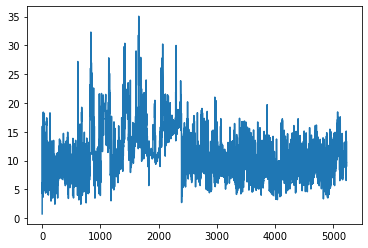

In [160]:
plt.plot(loss)

# Store results

In [175]:
# Flat
ae = keras.models.load_model('models/ae-flat.h5')
inputLayer = Input(shape = (14))    
embedder = inputLayer
for layer in ae.layers[:7]:
    embedder = layer(embedder)
embedder = Model(inputs=inputLayer, outputs=embedder)
activations = embedder(x_train_flat[:,0,:])
dec = ae.predict(x_train_flat[:,0,:])

pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_flat[:,0,:])
y_pca = pca.inverse_transform(red)

print('Pose-AE, flat, 2 dim, VAF: ' + str((1 - ((np.var(x_train_flat[:,0,:] - dec)) / (np.var(x_train_flat[:,0,:])))) * 100))
print('PCA, flat, 2 dim, VAF: ' + str((1 - ((np.var(x_train_flat[:,0,:] - y_pca)) / (np.var(x_train_flat[:,0,:])))) * 100))

# Stairs
ae = keras.models.load_model('models/ae-stairs.h5')
inputLayer = Input(shape = (14))    
embedder = inputLayer
for layer in ae.layers[:7]:
    embedder = layer(embedder)
embedder = Model(inputs=inputLayer, outputs=embedder)
activations = embedder(x_train_stairs[:,0,:])
dec = ae.predict(x_train_stairs[:,0,:])

pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_stairs[:,0,:])
y_pca = pca.inverse_transform(red)

print('Pose-AE, stairs, 2 dim, VAF: ' + str((1 - ((np.var(x_train_stairs[:,0,:] - dec)) / (np.var(x_train_stairs[:,0,:])))) * 100))
print('PCA, stairs, 2 dim, VAF: ' + str((1 - ((np.var(x_train_stairs[:,0,:] - y_pca)) / (np.var(x_train_stairs[:,0,:])))) * 100))

Pose-AE, flat, 2 dim, VAF: 85.32330673744273
PCA, flat, 2 dim, VAF: 65.84848837297037
Pose-AE, stairs, 2 dim, VAF: 69.3950062056926
PCA, stairs, 2 dim, VAF: 50.12398688232089


In [174]:
print('Pose-AE, flat, 2 dim, VAF: ' + str((1 - ((np.var(x_train_flat[:,0,:] - dec)) / (np.var(x_train_flat[:,0,:])))) * 100))
print('PCA, flat, 2 dim, VAF: ' + str((1 - ((np.var(x_train_flat[:,0,:] - y_pca)) / (np.var(x_train_flat[:,0,:])))) * 100))

Pose-AE, flat, 2 dim, VAF: 85.32330673744273
PCA, flat, 2 dim, VAF: 65.84848837363332
